# Importing Repositories

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy import stats
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize']=(20,10)

In [2]:
def missing_zero_values_table(df):
        ''''Takes a pandas dataframe and returns a statistics table that explains the missing and 
        zero values'''
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Our selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    
        return mz_table

# Importing data files

## Paths for files

In [3]:
path_price = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadPrices_12.1.D'
path_windsolar = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadGenerationForecastForWindAndSolar_14.1.D'

## Price Timeseries Importing

In [4]:
f_price = glob.glob(path_price + "/*.csv")
dprice = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_price]

price_ts = pd.concat(dprice)
price_ts = price_ts[price_ts['AreaCode'] == '10YGB----------A']
price_ts = price_ts[['DateTime', 'Price']]
price_ts.sort_values(by='DateTime', ascending=True)
price_ts.reset_index(drop=True)
price_ts.set_index('DateTime', inplace=True)
price_ts = price_ts.resample('H').fillna('nearest')
price_ts


,Price
DateTime,
2014-12-18 23:00:00,39.91
2014-12-19 00:00:00,36.59
2014-12-19 01:00:00,31.91
2014-12-19 02:00:00,22.53
2014-12-19 03:00:00,20.96
...,...
2020-12-31 18:00:00,71.30
2020-12-31 19:00:00,61.04
2020-12-31 20:00:00,60.39


In [5]:
price_ts.to_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\historic_price.csv')

## Wind and Solar Timeseries Importing

### Wind Off Shore

In [6]:
f_windoff = glob.glob(path_windsolar + "/*.csv")
dwindoff = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windoff]

windoff_ts = pd.concat(dwindoff)
windoff_ts = windoff_ts[windoff_ts['AreaCode'] == '10YGB----------A']
windoff_ts = windoff_ts[windoff_ts['ProductionType'] == 'Wind Offshore']
windoff_ts = windoff_ts[['DateTime', 'AggregatedGenerationForecast']]
windoff_ts.rename(columns={"AggregatedGenerationForecast":"Wind OffGeneration"}, inplace=True)
windoff_ts.sort_values(by='DateTime', ascending=True)
windoff_ts.reset_index(drop=True)
windoff_ts.drop_duplicates(subset=['DateTime'], inplace=True)
windoff_ts.set_index('DateTime', inplace=True)
test = pd.merge(price_ts, windoff_ts, right_index=True, left_index=True)
test = test.asfreq('H')
test.index


DatetimeIndex(['2014-12-30 00:00:00', '2014-12-30 01:00:00',
               '2014-12-30 02:00:00', '2014-12-30 03:00:00',
               '2014-12-30 04:00:00', '2014-12-30 05:00:00',
               '2014-12-30 06:00:00', '2014-12-30 07:00:00',
               '2014-12-30 08:00:00', '2014-12-30 09:00:00',
               ...
               '2020-12-31 13:00:00', '2020-12-31 14:00:00',
               '2020-12-31 15:00:00', '2020-12-31 16:00:00',
               '2020-12-31 17:00:00', '2020-12-31 18:00:00',
               '2020-12-31 19:00:00', '2020-12-31 20:00:00',
               '2020-12-31 21:00:00', '2020-12-31 22:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=52655, freq='H')

### Wind On Shore Data

In [7]:
f_windon = glob.glob(path_windsolar + "/*.csv")
dwindon = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windon]

windon_ts = pd.concat(dwindon)
windon_ts = windon_ts[windon_ts['AreaCode'] == '10YGB----------A']
windon_ts = windon_ts[windon_ts['ProductionType'] == 'Wind Onshore']
windon_ts = windon_ts[['DateTime', 'AggregatedGenerationForecast']]
windon_ts.rename(columns={"AggregatedGenerationForecast":"Wind OnGeneration"}, inplace=True)
windon_ts.sort_values(by='DateTime', ascending=True)
windon_ts.reset_index(drop=True)
windon_ts.drop_duplicates(subset=['DateTime'], inplace=True)
windon_ts.set_index('DateTime', inplace=True)
test = pd.merge(test, windon_ts, right_index=True, left_index=True)

### Solar Data

In [8]:
f_solar = glob.glob(path_windsolar + "/*.csv")
dsolar = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_solar]

solar_ts = pd.concat(dsolar)
solar_ts = solar_ts[solar_ts['AreaCode'] == '10YGB----------A']
solar_ts = solar_ts[solar_ts['ProductionType'] == 'Solar']
solar_ts = solar_ts[['DateTime', 'AggregatedGenerationForecast']]
solar_ts.rename(columns={"AggregatedGenerationForecast":"Solar Generation"}, inplace=True)
solar_ts.sort_values(by='DateTime', ascending=True)
solar_ts.reset_index(drop=True)
solar_ts.drop_duplicates(subset=['DateTime'], inplace=True)
solar_ts.set_index('DateTime', inplace=True)
test = pd.merge(test, solar_ts, right_index=True, left_index=True)

### Demand Data

In [9]:
ddemand = pd.read_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\demandto2020.csv',
                       parse_dates=['time'])
demand_ts = ddemand[['time', 'ND']]
demand_ts.rename(columns={"time":"DateTime",
                          "ND":"Demand"}, inplace=True)

demand_ts.sort_values(by='DateTime', ascending=True)
demand_ts.reset_index(drop=True, inplace=True)
demand_ts.set_index('DateTime', inplace=True)
demand_ts = demand_ts.resample('H').sum()
df_model = pd.merge(test, demand_ts, right_index=True, left_index=True)

In [10]:
df_model

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand
DateTime,,,,,
2014-12-30 00:00:00,42.97,996.58,2363.80,0.0,63271
2014-12-30 01:00:00,40.13,1059.20,2413.88,0.0,60951
2014-12-30 02:00:00,36.90,1123.27,2450.75,0.0,59496
2014-12-30 03:00:00,34.98,1177.54,2500.78,0.0,57390
2014-12-30 04:00:00,33.63,1188.21,2536.07,0.0,55862
...,...,...,...,...,...
2020-12-31 18:00:00,71.30,2644.97,3028.41,0.0,85279
2020-12-31 19:00:00,61.04,2707.55,3046.72,0.0,83146
2020-12-31 20:00:00,60.39,2695.01,3053.60,0.0,77395


In [11]:
df_model.index

DatetimeIndex(['2014-12-30 00:00:00', '2014-12-30 01:00:00',
               '2014-12-30 02:00:00', '2014-12-30 03:00:00',
               '2014-12-30 04:00:00', '2014-12-30 05:00:00',
               '2014-12-30 06:00:00', '2014-12-30 07:00:00',
               '2014-12-30 08:00:00', '2014-12-30 09:00:00',
               ...
               '2020-12-31 13:00:00', '2020-12-31 14:00:00',
               '2020-12-31 15:00:00', '2020-12-31 16:00:00',
               '2020-12-31 17:00:00', '2020-12-31 18:00:00',
               '2020-12-31 19:00:00', '2020-12-31 20:00:00',
               '2020-12-31 21:00:00', '2020-12-31 22:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=52631, freq=None)

In [12]:
df_model =  df_model.resample('H').fillna('nearest')

## Transforming Solar, Wind Onshore and Wind Offshore Generation values

In [13]:
# Apply square root transformation to our predictors in order to have the scale with our dependent variable (Price)

# df_model['Solar Generation'] = df_model['Solar Generation'].transform('sqrt')
# df_model['Wind OffGeneration'] = df_model['Wind OffGeneration'].transform('sqrt')
# df_model['Wind OnGeneration'] = df_model['Wind OnGeneration'].transform('sqrt')
# df_model['Demand'] = df_model['Demand'].transform('sqrt')
df_model

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand
DateTime,,,,,
2014-12-30 00:00:00,42.97,996.58,2363.80,0.0,63271
2014-12-30 01:00:00,40.13,1059.20,2413.88,0.0,60951
2014-12-30 02:00:00,36.90,1123.27,2450.75,0.0,59496
2014-12-30 03:00:00,34.98,1177.54,2500.78,0.0,57390
2014-12-30 04:00:00,33.63,1188.21,2536.07,0.0,55862
...,...,...,...,...,...
2020-12-31 18:00:00,71.30,2644.97,3028.41,0.0,85279
2020-12-31 19:00:00,61.04,2707.55,3046.72,0.0,83146
2020-12-31 20:00:00,60.39,2695.01,3053.60,0.0,77395


Text(0.5, 1.0, 'Price Timeseries')

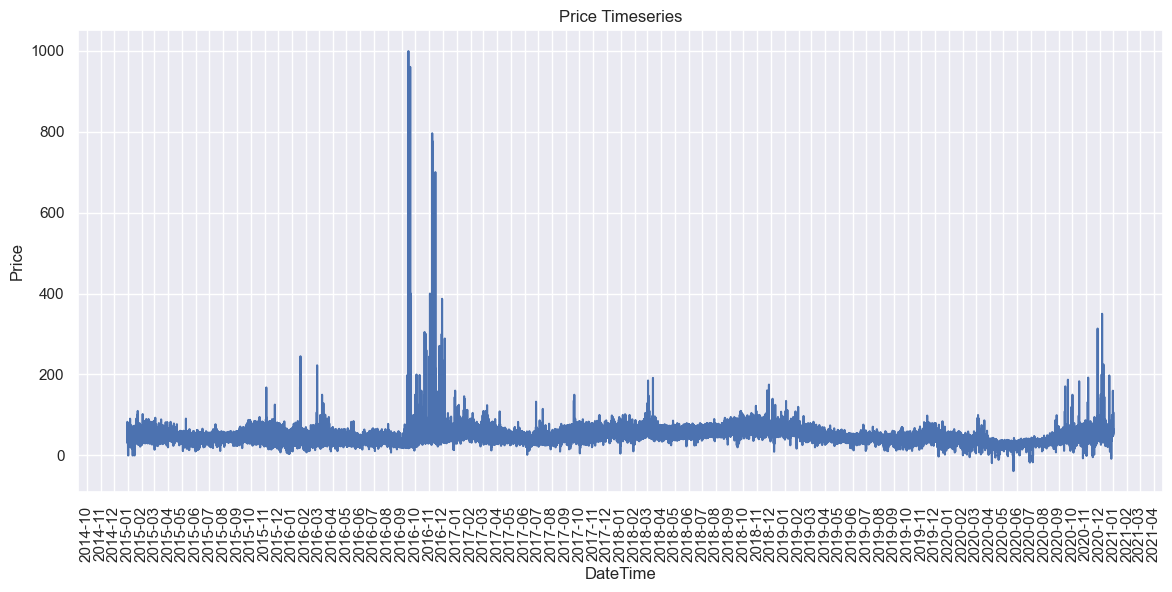

In [14]:
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x=df_model.index, y=df_model['Price'], ax=ax)
month_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
plt.xticks(rotation=90)
plt.title('Price Timeseries')
# plt.savefig(r'C:\Users\2836589S\OneDrive - University of Glasgow\VScode Projects\Price Timeseries UK\Plots\Timeseries Plots\price_timeseries.png')

Text(0.5, 1.0, 'Solar Generation Timeseries')

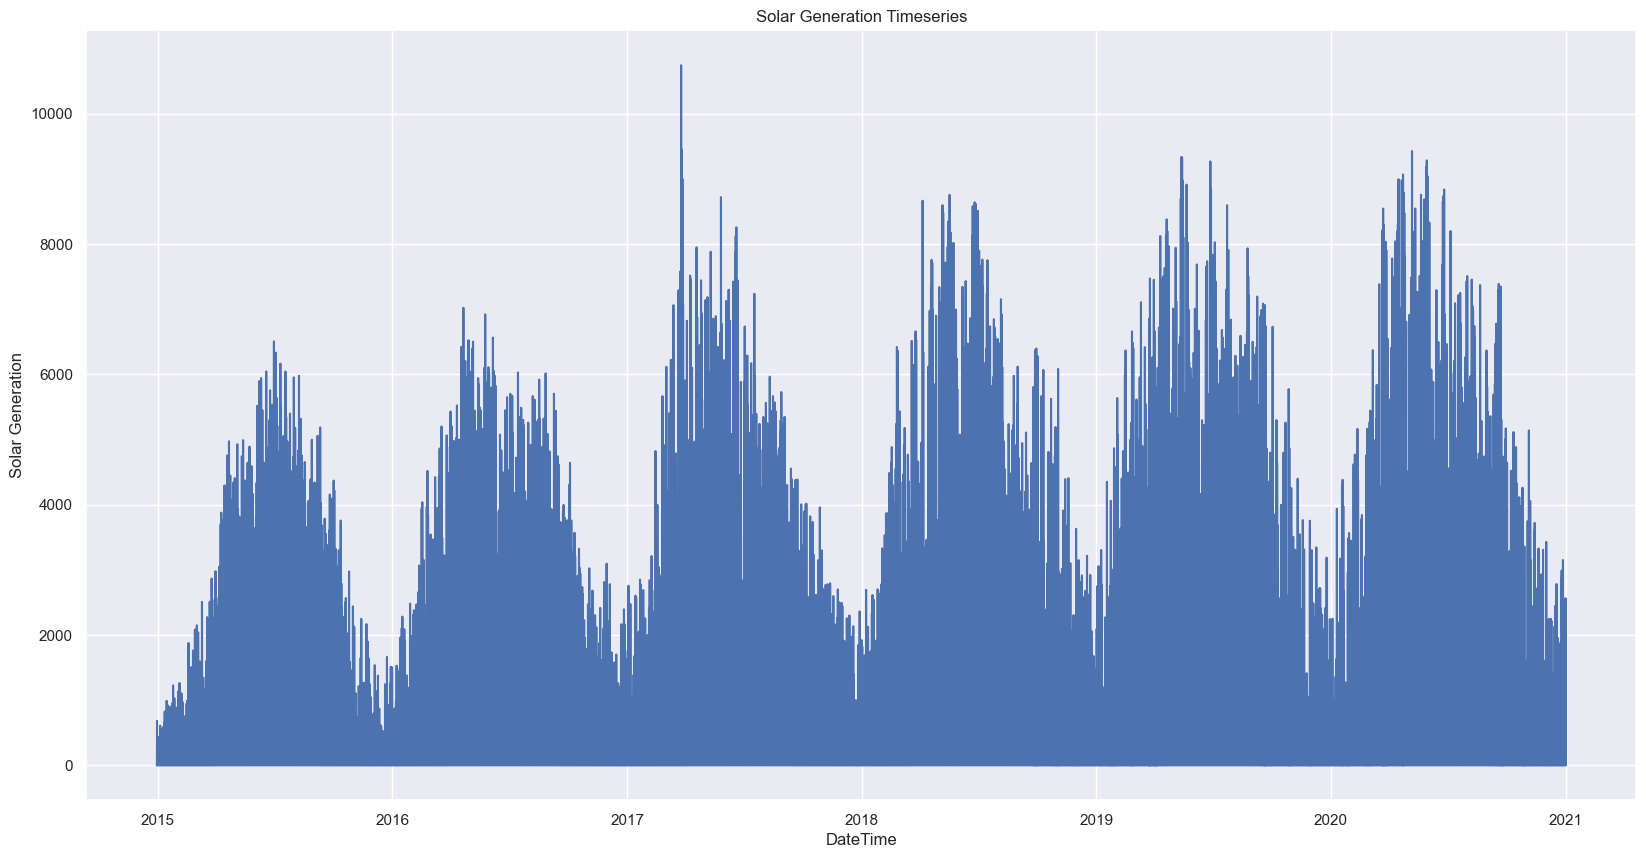

In [15]:
sns.lineplot(x=df_model.index, y=df_model['Solar Generation'])
plt.title('Solar Generation Timeseries')
# plt.savefig(r'C:\Users\2836589S\OneDrive - University of Glasgow\VScode Projects\Price Timeseries UK\Plots\Timeseries Plots\solar_timeseries.png')

Text(0.5, 1.0, 'Wind Offshore Generation Timeseries')

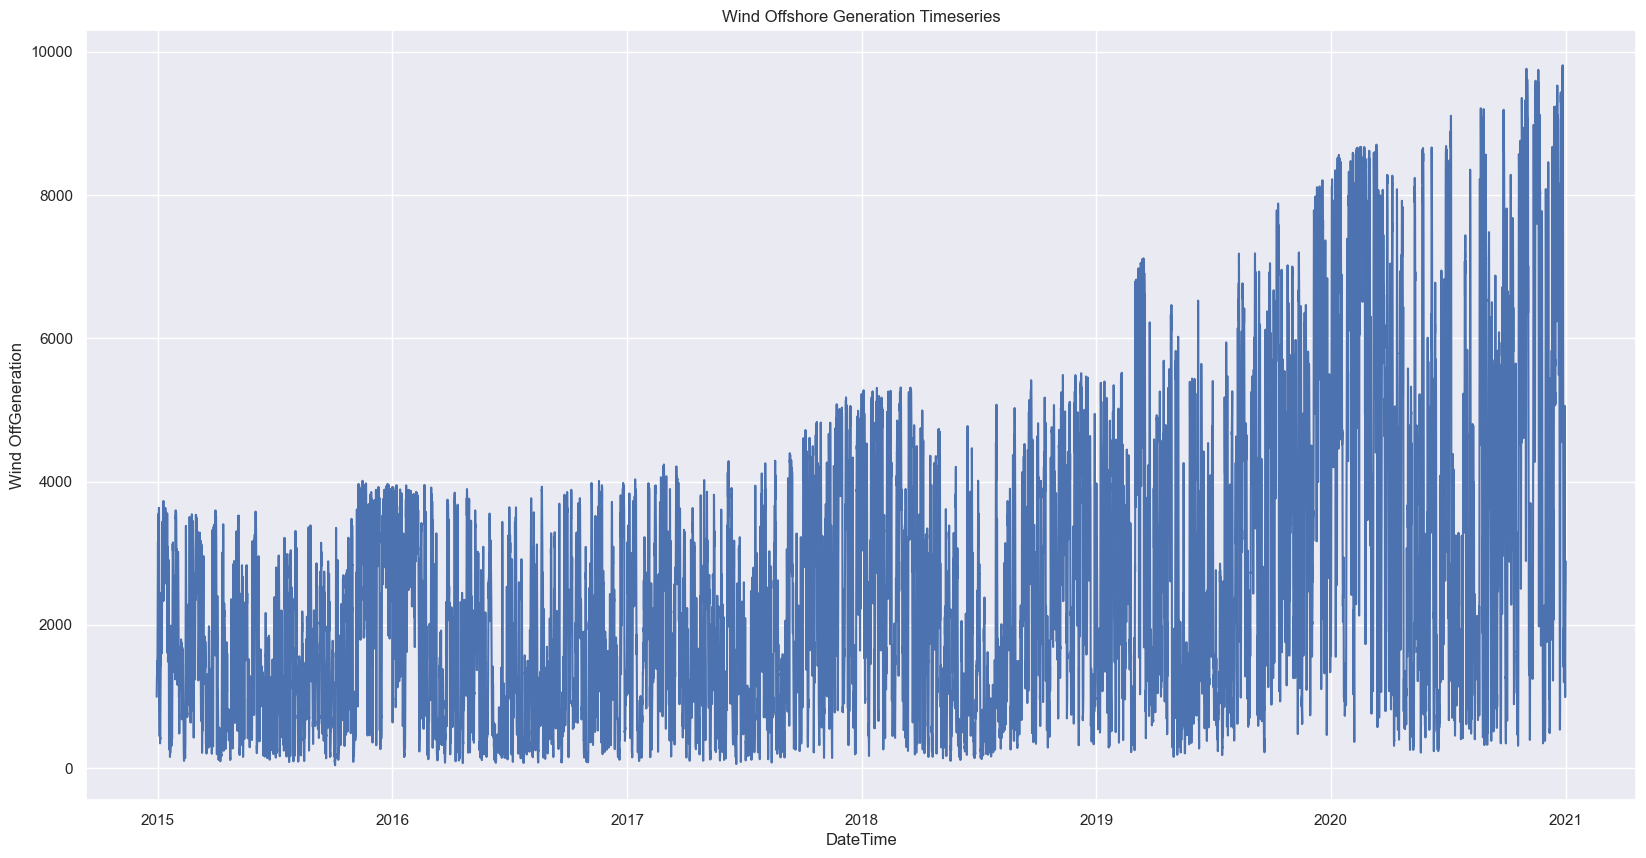

In [16]:
sns.lineplot(x=df_model.index, y=df_model['Wind OffGeneration'])
plt.title('Wind Offshore Generation Timeseries')
# plt.savefig(r'C:\Users\2836589S\OneDrive - University of Glasgow\VScode Projects\Price Timeseries UK\Plots\Timeseries Plots\windoff_timeseries.png')

Text(0.5, 1.0, 'Wind Onshore Generation Timeseries')

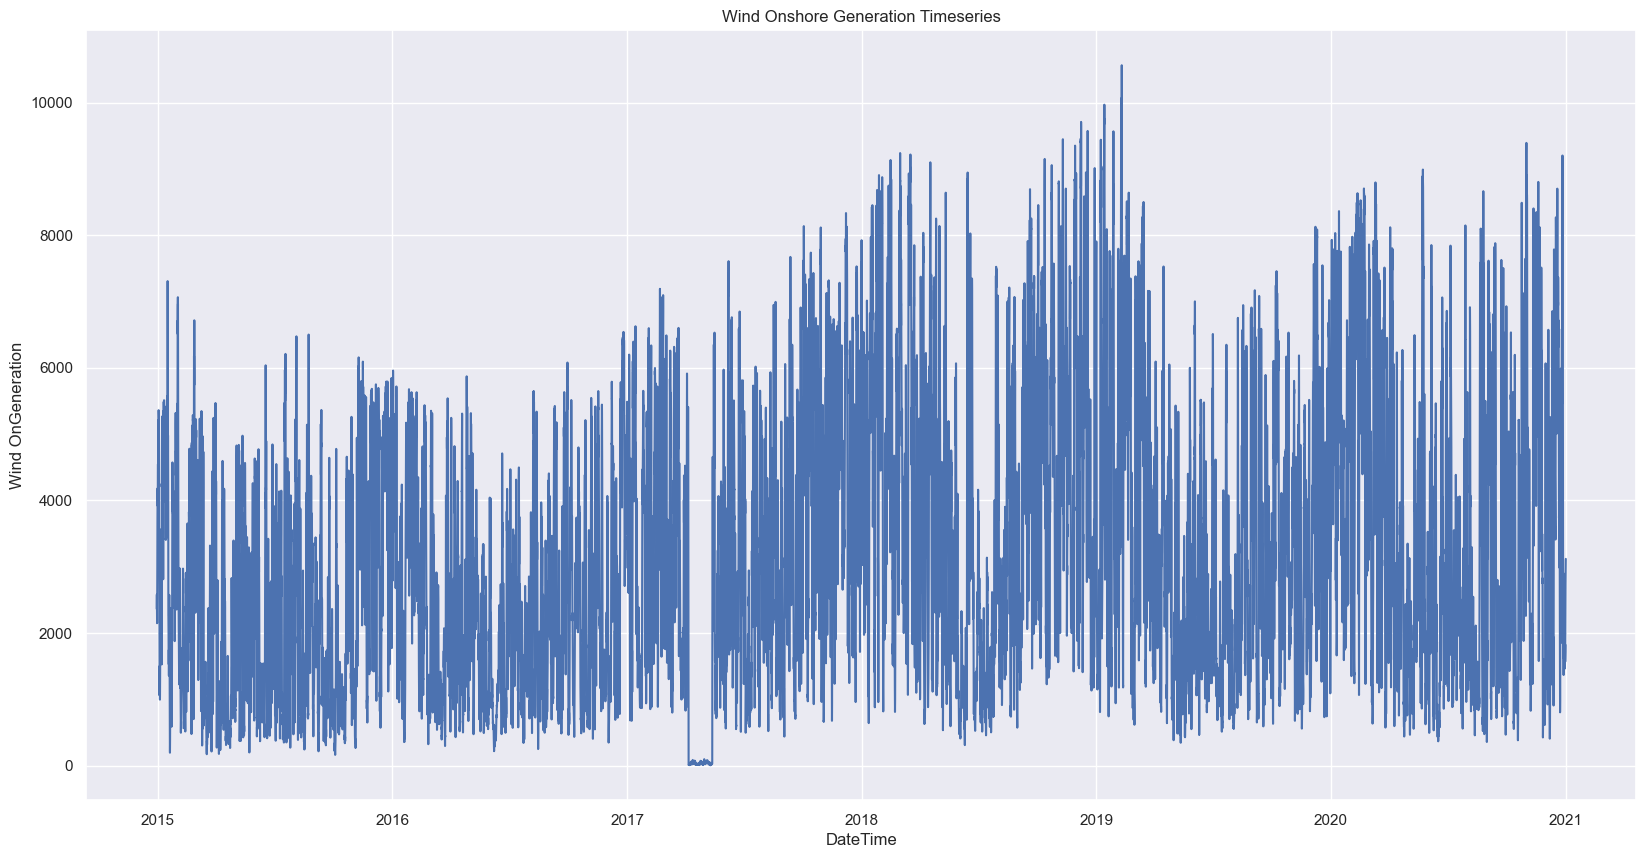

In [17]:
sns.lineplot(x=df_model.index, y=df_model['Wind OnGeneration'])
plt.title('Wind Onshore Generation Timeseries')
# plt.savefig(r'C:\Users\2836589S\OneDrive - University of Glasgow\VScode Projects\Price Timeseries UK\Plots\Timeseries Plots\windon_timeseries.png')

Text(0.5, 1.0, 'Demand Timeseries')

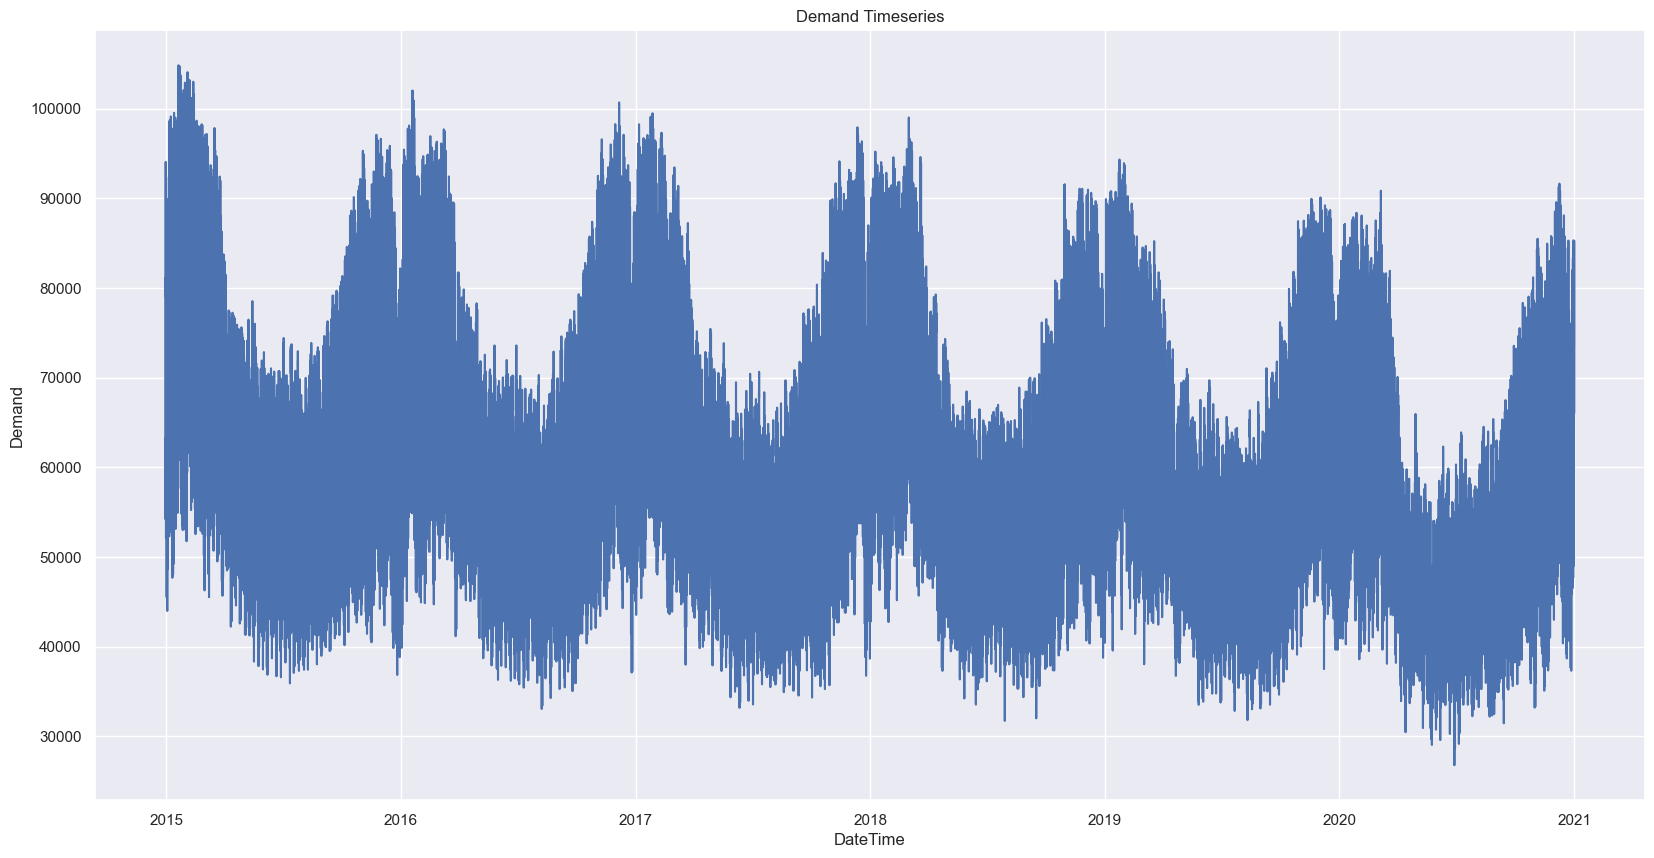

In [18]:
sns.lineplot(x=df_model.index, y=df_model['Demand'])
plt.title('Demand Timeseries')
# # plt.savefig(r'C:\Users\2836589S\OneDrive - University of Glasgow\VScode Projects\Price Timeseries UK\Plots\Timeseries Plots\demand_timeseries.png')

In [19]:
# Selecting the timeseries we will study further on.

df_model = df_model.loc['2016-12-1':'2020-09-30']

# Creating lags - 1-week-lags

In [20]:
def lag_col(df, variable, lags):
    '''
        Takes in a pandas dataframe, a specific variable of the dataset and number of lags as a list
        and returns the df updated with the lags of the variable
        
        Parameters:
            df: pandas dataframe
            variable: string
            lags: list
        
        Returns:
            Adds column for every lag inside the list for our designated variable
        
        '''


    for lag in lags:
        df[str(variable) + '_' + str(lag)] = df[variable].shift(lag)
    return df

In [21]:
lags = list(range(1,168)) # 1-week-lags

In [22]:
lag_col(df_model, 'Price', lags)

# Bellow are lines that create lags on the other covariates

# lag_col(df_model, 'Solar Generation', lags)
# lag_col(df_model, 'Wind OffGeneration', lags)
# lag_col(df_model, 'Wind OnGeneration', lags)
# lag_col(df_model, 'Demand', lags)

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand,Price_1,Price_2,Price_3,Price_4,Price_5,...,Price_158,Price_159,Price_160,Price_161,Price_162,Price_163,Price_164,Price_165,Price_166,Price_167
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-12-01 00:00:00,45.01,1449.06,3723.76,0.0,62887,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 01:00:00,42.09,1565.10,3775.25,0.0,60602,45.01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 02:00:00,39.59,1605.00,3817.50,0.0,59697,42.09,45.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 03:00:00,37.94,1628.37,3895.91,0.0,58078,39.59,42.09,45.01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 04:00:00,36.79,1636.05,3918.80,0.0,56809,37.94,39.59,42.09,45.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00,46.55,7773.13,2859.31,0.0,72085,59.49,67.72,56.82,50.12,43.70,...,48.09,39.73,31.41,26.98,29.27,33.02,34.98,39.09,37.42,41.52
2020-09-30 20:00:00,40.95,7812.94,2772.00,0.0,67465,46.55,59.49,67.72,56.82,50.12,...,48.58,48.09,39.73,31.41,26.98,29.27,33.02,34.98,39.09,37.42
2020-09-30 21:00:00,34.84,7679.28,2653.40,0.0,61393,40.95,46.55,59.49,67.72,56.82,...,49.88,48.58,48.09,39.73,31.41,26.98,29.27,33.02,34.98,39.09


In [23]:
missing_zero_values_table(df_model)

Our selected dataframe has 172 columns and 33600 Rows.
There are 167 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Price_167,9,167,0.5,176,0.5,float64
Price_166,9,166,0.5,175,0.5,float64
Price_165,9,165,0.5,174,0.5,float64
Price_164,9,164,0.5,173,0.5,float64
Price_163,9,163,0.5,172,0.5,float64
...,...,...,...,...,...,...
Price_5,9,5,0.0,14,0.0,float64
Price_4,9,4,0.0,13,0.0,float64
Price_3,9,3,0.0,12,0.0,float64
Price_2,9,2,0.0,11,0.0,float64


In [24]:
# We are losing 167 hours, so these will be the first two weeks of December 2016

In [25]:
# Extracting the hours in a seperate column

df_model['Hour'] = df_model.index.hour
df_model

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand,Price_1,Price_2,Price_3,Price_4,Price_5,...,Price_159,Price_160,Price_161,Price_162,Price_163,Price_164,Price_165,Price_166,Price_167,Hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-12-01 00:00:00,45.01,1449.06,3723.76,0.0,62887,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-12-01 01:00:00,42.09,1565.10,3775.25,0.0,60602,45.01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2016-12-01 02:00:00,39.59,1605.00,3817.50,0.0,59697,42.09,45.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2016-12-01 03:00:00,37.94,1628.37,3895.91,0.0,58078,39.59,42.09,45.01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2016-12-01 04:00:00,36.79,1636.05,3918.80,0.0,56809,37.94,39.59,42.09,45.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00,46.55,7773.13,2859.31,0.0,72085,59.49,67.72,56.82,50.12,43.70,...,39.73,31.41,26.98,29.27,33.02,34.98,39.09,37.42,41.52,19
2020-09-30 20:00:00,40.95,7812.94,2772.00,0.0,67465,46.55,59.49,67.72,56.82,50.12,...,48.09,39.73,31.41,26.98,29.27,33.02,34.98,39.09,37.42,20
2020-09-30 21:00:00,34.84,7679.28,2653.40,0.0,61393,40.95,46.55,59.49,67.72,56.82,...,48.58,48.09,39.73,31.41,26.98,29.27,33.02,34.98,39.09,21


In [26]:
df_model.dropna(inplace=True) # Clearing na values

# Re-forming our dataset

## Creating single-hour data blocks

In [27]:
#Create multi-dataframe that will have every single dataset regarding the time of the day

hours = df_model['Hour'].unique().tolist()
hours.sort()
df_hour ={hour: pd.DataFrame() for hour in hours}
for i in range(len(hours)):
    df_hour[i] = df_model[df_model['Hour'] == i]
    


# Example of the dataset of 00:00    
df_hour[1]


,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand,Price_1,Price_2,Price_3,Price_4,Price_5,...,Price_159,Price_160,Price_161,Price_162,Price_163,Price_164,Price_165,Price_166,Price_167,Hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-12-08 01:00:00,36.25,2986.97,4590.27,0.0,54646,37.76,37.92,36.46,38.20,48.32,...,52.44,55.97,55.01,51.65,41.96,38.04,36.79,37.94,39.59,1
2016-12-09 01:00:00,37.33,989.59,2440.66,0.0,56597,40.44,40.87,36.07,42.06,48.34,...,58.58,64.88,69.36,55.51,40.99,39.50,39.01,39.09,40.48,1
2016-12-10 01:00:00,40.26,2705.68,4038.47,0.0,54862,40.25,43.58,34.24,35.94,43.98,...,53.24,57.55,51.31,41.02,39.99,38.61,38.08,39.94,40.29,1
2016-12-11 01:00:00,38.59,2073.47,4114.45,0.0,53397,40.93,42.07,36.08,41.93,44.72,...,41.30,39.56,38.08,36.49,35.00,31.43,30.45,34.25,38.00,1
2016-12-12 01:00:00,37.02,429.59,1246.44,0.0,55787,37.34,37.41,40.09,49.93,49.90,...,53.80,54.80,54.50,55.61,54.31,37.18,36.34,31.58,32.36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26 01:00:00,23.23,8847.27,4908.71,0.0,38228,26.20,28.71,31.80,33.14,42.97,...,37.03,36.96,40.00,38.75,37.42,34.60,32.06,28.73,29.21,1
2020-09-27 01:00:00,13.69,7654.24,2511.73,0.0,38205,16.95,18.77,35.13,38.00,44.94,...,48.17,43.60,45.00,36.00,32.79,32.28,32.54,31.99,32.00,1
2020-09-28 01:00:00,26.77,4323.23,1391.80,0.0,41959,27.61,28.85,31.38,36.65,41.23,...,58.85,62.37,61.06,67.43,75.86,52.10,45.76,36.95,30.03,1


In [28]:
for h in hours:
    for i in range(1,h+1):
        df_hour[h].drop(columns=['Price_'+str(i)], inplace=True)

In [29]:
for h in hours:
    df_hour[h].rename(columns={'Price_'+str(h+1):'Price_Recent'}, inplace=True)     

In [30]:
df_hour[0]

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand,Price_Recent,Price_2,Price_3,Price_4,Price_5,...,Price_159,Price_160,Price_161,Price_162,Price_163,Price_164,Price_165,Price_166,Price_167,Hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-12-08,37.76,3192.99,4746.20,0.0,56426,37.92,36.46,38.20,48.32,56.22,...,55.97,55.01,51.65,41.96,38.04,36.79,37.94,39.59,42.09,0
2016-12-09,40.44,953.12,2308.48,0.0,58924,40.87,36.07,42.06,48.34,54.94,...,64.88,69.36,55.51,40.99,39.50,39.01,39.09,40.48,42.41,0
2016-12-10,40.25,2944.11,4100.36,0.0,56467,43.58,34.24,35.94,43.98,49.46,...,57.55,51.31,41.02,39.99,38.61,38.08,39.94,40.29,42.07,0
2016-12-11,40.93,1974.59,3983.59,0.0,55111,42.07,36.08,41.93,44.72,49.78,...,39.56,38.08,36.49,35.00,31.43,30.45,34.25,38.00,40.34,0
2016-12-12,37.34,540.73,1150.81,0.0,57390,37.41,40.09,49.93,49.90,55.77,...,54.80,54.50,55.61,54.31,37.18,36.34,31.58,32.36,36.14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26,26.20,8836.53,4958.44,0.0,39535,28.71,31.80,33.14,42.97,54.00,...,36.96,40.00,38.75,37.42,34.60,32.06,28.73,29.21,29.80,0
2020-09-27,16.95,7790.02,2687.13,0.0,39331,18.77,35.13,38.00,44.94,51.04,...,43.60,45.00,36.00,32.79,32.28,32.54,31.99,32.00,32.17,0
2020-09-28,27.61,4389.08,1218.13,0.0,42603,28.85,31.38,36.65,41.23,50.00,...,62.37,61.06,67.43,75.86,52.10,45.76,36.95,30.03,31.02,0


In [31]:
# Dropping unwanted features for every single dataset and dropping the nan values
for i in range(len(hours)):
    df_hour[i].drop(columns=['Hour'], inplace=True)

# Example of data frame regarding the 23:00 data frame
df_hour[23]

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand,Price_Recent,Price_25,Price_26,Price_27,Price_28,...,Price_158,Price_159,Price_160,Price_161,Price_162,Price_163,Price_164,Price_165,Price_166,Price_167
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-12-07 23:00:00,37.92,3532.74,5138.59,0.0,63662,39.91,37.94,40.62,48.99,57.42,...,55.97,55.01,51.65,41.96,38.04,36.79,37.94,39.59,42.09,45.01
2016-12-08 23:00:00,40.87,1207.81,2616.05,0.0,66323,37.92,36.46,38.20,48.32,56.22,...,64.88,69.36,55.51,40.99,39.50,39.01,39.09,40.48,42.41,44.56
2016-12-09 23:00:00,43.58,3029.14,4544.63,0.0,62383,40.87,36.07,42.06,48.34,54.94,...,57.55,51.31,41.02,39.99,38.61,38.08,39.94,40.29,42.07,48.97
2016-12-10 23:00:00,42.07,2324.71,4229.84,0.0,60608,43.58,34.24,35.94,43.98,49.46,...,39.56,38.08,36.49,35.00,31.43,30.45,34.25,38.00,40.34,51.00
2016-12-11 23:00:00,37.41,530.54,1194.77,0.0,64631,42.07,36.08,41.93,44.72,49.78,...,54.80,54.50,55.61,54.31,37.18,36.34,31.58,32.36,36.14,37.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26 23:00:00,18.77,8299.65,3305.54,0.0,43163,28.71,31.80,33.14,42.97,54.00,...,43.60,45.00,36.00,32.79,32.28,32.54,31.99,32.00,32.17,33.08
2020-09-27 23:00:00,28.85,4662.25,1068.88,0.0,46340,18.77,35.13,38.00,44.94,51.04,...,62.37,61.06,67.43,75.86,52.10,45.76,36.95,30.03,31.02,33.30
2020-09-28 23:00:00,36.10,1272.34,1488.26,0.0,48171,28.85,31.38,36.65,41.23,50.00,...,42.00,52.85,57.00,65.60,48.02,38.03,37.06,35.90,35.90,37.10


In [32]:
df_hour[0]

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Demand,Price_Recent,Price_2,Price_3,Price_4,Price_5,...,Price_158,Price_159,Price_160,Price_161,Price_162,Price_163,Price_164,Price_165,Price_166,Price_167
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-12-08,37.76,3192.99,4746.20,0.0,56426,37.92,36.46,38.20,48.32,56.22,...,52.44,55.97,55.01,51.65,41.96,38.04,36.79,37.94,39.59,42.09
2016-12-09,40.44,953.12,2308.48,0.0,58924,40.87,36.07,42.06,48.34,54.94,...,58.58,64.88,69.36,55.51,40.99,39.50,39.01,39.09,40.48,42.41
2016-12-10,40.25,2944.11,4100.36,0.0,56467,43.58,34.24,35.94,43.98,49.46,...,53.24,57.55,51.31,41.02,39.99,38.61,38.08,39.94,40.29,42.07
2016-12-11,40.93,1974.59,3983.59,0.0,55111,42.07,36.08,41.93,44.72,49.78,...,41.30,39.56,38.08,36.49,35.00,31.43,30.45,34.25,38.00,40.34
2016-12-12,37.34,540.73,1150.81,0.0,57390,37.41,40.09,49.93,49.90,55.77,...,53.80,54.80,54.50,55.61,54.31,37.18,36.34,31.58,32.36,36.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26,26.20,8836.53,4958.44,0.0,39535,28.71,31.80,33.14,42.97,54.00,...,37.03,36.96,40.00,38.75,37.42,34.60,32.06,28.73,29.21,29.80
2020-09-27,16.95,7790.02,2687.13,0.0,39331,18.77,35.13,38.00,44.94,51.04,...,48.17,43.60,45.00,36.00,32.79,32.28,32.54,31.99,32.00,32.17
2020-09-28,27.61,4389.08,1218.13,0.0,42603,28.85,31.38,36.65,41.23,50.00,...,58.85,62.37,61.06,67.43,75.86,52.10,45.76,36.95,30.03,31.02


# Lasso - Garch Model

## Dataset Split

In [115]:
from sklearn.model_selection import train_test_split




# Splitting every dataset for our dependent and independent variables 
X_train = {hour: pd.DataFrame() for hour in hours}
y_train = {hour: pd.DataFrame() for hour in hours}
X_test = {hour: pd.DataFrame() for hour in hours}
y_test = {hour: pd.DataFrame() for hour in hours}



for hour in range(len(hours)):
    X_train[hour], X_test[hour], y_train[hour], y_test[hour] = train_test_split(df_hour[hour].drop(columns='Price'),
                                                                                df_hour[hour]['Price'],
                                                                                test_size=0.20,
                                                                                shuffle=False)
    

## Lasso Regressor and TimeSeriesSplit

In [116]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Creating datasets that will store the models and the prediction prices
y_pred = {hour: pd.DataFrame() for hour in hours}
model_train = {hour: pd.DataFrame() for hour in hours}
y_train_pred = {hour: pd.DataFrame() for hour in hours}

# Lists to fill for the scores
rsquared_test = []
rsquared_train = []
model_name = []
mae = []
rmse = []
alpha = []



for hour in hours:
    # Creating fold strategy
    tscv = TimeSeriesSplit(n_splits=5)
    num_cols = df_hour[hour].drop(columns=['Price']).columns.to_list()
    num_pipeline = Pipeline(steps=[
        ('scale', StandardScaler())
        ])
    trans_pipeline = ColumnTransformer(transformers=[
        ('num_pipeline', num_pipeline, num_cols)
    ], remainder='drop', n_jobs=-1)

    Lasso = LassoCV(cv=tscv, random_state=0)

    lasso_pipeline = Pipeline(steps=[
        ('trans_pipeline', trans_pipeline),
        ('model', Lasso)
    ])

    model_train[hour] = lasso_pipeline.fit(X_train[hour], y_train[hour])
    y_train_pred[hour] = model_train[hour].predict(X_train[hour])
    y_pred[hour]= model_train[hour].predict(X_test[hour])
    train_score = r2_score(y_train[hour], y_train_pred[hour])
    test_score = r2_score(y_test[hour], y_pred[hour])
    mae_score = mean_absolute_error(y_test[hour], y_pred[hour])
    rmse_score = mean_squared_error(y_test[hour], y_pred[hour])
    mae.append(mae_score)
    rmse.append(rmse_score)
    rsquared_test.append(test_score)
    rsquared_train.append(train_score)
    alpha.append(model_train[hour][1].alpha_)

    model_name.append('LASSO-D FOR HOUR_[' + str(hour) + ']')


model_results = pd.DataFrame(columns=['Model', 'Rsquared Value Train', 'Rsquared Value Test', 'Smoothing Parameter'])
model_results['Model'] = model_name
model_results['Rsquared Value Train'] = rsquared_train
model_results['Rsquared Value Test'] = rsquared_test
model_results['MAE Score'] = mae
model_results['RMSE Score'] = rmse
model_results['Smoothing Parameter'] = alpha

# Table that shows the results for every trained model
model_results
    


,Model,Rsquared Value Train,Rsquared Value Test,Smoothing Parameter,MAE Score,RMSE Score
0,LASSO-D FOR HOUR_[0],0.902528,0.907310,0.089977,1.777142,6.568795
1,LASSO-D FOR HOUR_[1],0.878640,0.802073,0.104994,2.714510,15.114373
2,LASSO-D FOR HOUR_[2],0.846797,0.739065,0.094307,3.290789,21.313469
3,LASSO-D FOR HOUR_[3],0.817321,0.699778,0.100474,3.745250,28.665222
4,LASSO-D FOR HOUR_[4],0.768156,0.663485,0.147282,4.457915,39.227317
5,LASSO-D FOR HOUR_[5],0.755600,0.589416,0.142177,5.235954,52.025152
6,LASSO-D FOR HOUR_[6],0.782729,0.580479,0.141473,6.187444,69.575848
7,LASSO-D FOR HOUR_[7],0.817802,0.587647,0.101886,6.076535,59.347244
8,LASSO-D FOR HOUR_[8],0.780203,0.653211,0.133469,4.682625,39.187050
9,LASSO-D FOR HOUR_[9],0.759677,0.706777,0.193757,4.056812,29.119531


In [117]:
model_results.to_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\day_ahead_demand_parameters\lasso_demand_parameter.csv')

In [118]:
model_train[1][1].alpha_

0.10499436291178234

In [119]:
mae_score

4.52004329315789

In [120]:
model_results['Rsquared Value Train'].mean()

0.7839200824119635

In [121]:
model_results['Rsquared Value Test'].mean()

0.5935377743147688

In [122]:
model_results['MAE Score'].mean()

4.424901094441963

In [123]:
model_results['RMSE Score'].mean()

44.72515537652203

In [124]:
# Create multi data frame that will inform us about its coefficients with a descending order

df_coef = {hour: pd.DataFrame() for hour in hours}
for hour in hours:
    df_coef[hour].index = X_train[hour].transpose().index
    df_coef[hour]['Coefficients'] = model_train[hour]['model'].coef_.transpose()
    df_coef[hour].sort_values(by='Coefficients', ascending=False, inplace=True)
    df_coef[hour]


In [125]:
for hour in hours:
    df_coef[hour]['Hour'] = hour
    df_coef[hour].to_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\df_coef\df_coef_'+str(hour)+'.csv')




Text(0.5, 0, 'Coefficients')

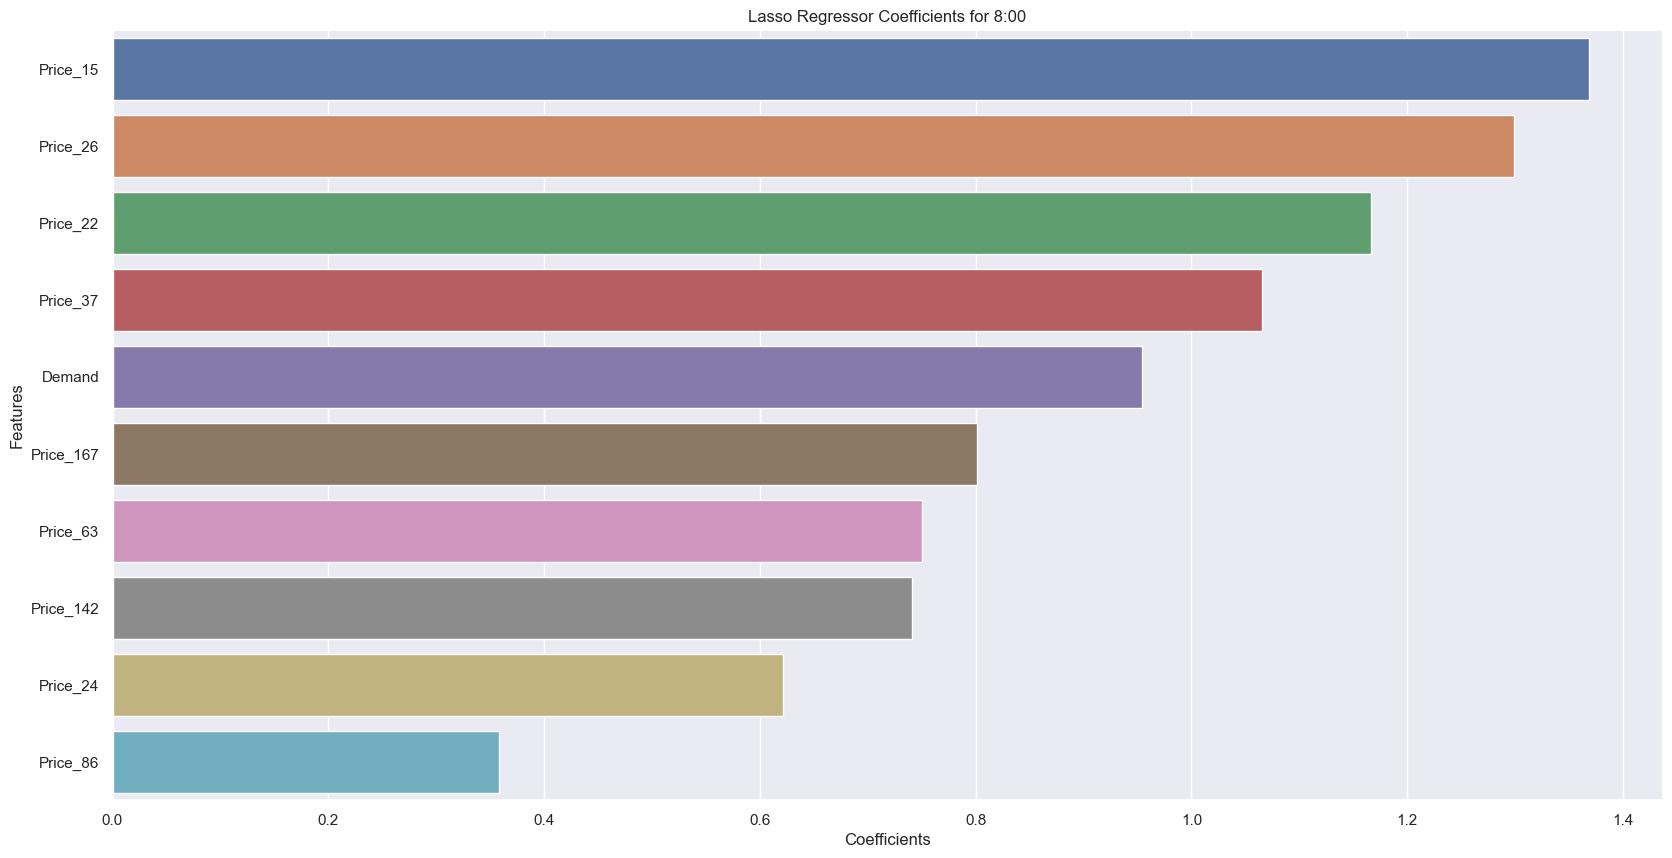

In [126]:
# Barplot for top 10 coeffiecients (features) for hour 8:00
a = df_coef[12].head(10)
sns.barplot(x=a['Coefficients'],y=a.index )
plt.title('Lasso Regressor Coefficients for 8:00')
plt.ylabel('Features')
plt.xlabel('Coefficients')

In [127]:
# Create multi data frame that will provides us with the residuals and squared residuals for every trained model, 
# for every hour


lasso_train = {hour: pd.DataFrame() for hour in hours}
lasso_test = {hour: pd.DataFrame() for hour in hours}

for hour in hours:
    scaler = StandardScaler()
    scaler.fit(X_train[hour])
    lasso_train[hour] = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
    lasso_train[hour]['Actual Value'] = y_train[hour]
    lasso_train[hour]['Predicted Value'] = model_train[hour].predict(X_train[hour])
    lasso_train[hour]['Residual'] = lasso_train[hour]['Actual Value'] - lasso_train[hour]['Predicted Value']
    lasso_train[hour]['Squared Residuals'] = lasso_train[hour]['Residual'].mul(lasso_train[hour]['Residual'])

for hour in hours:
    scaler = StandardScaler()
    scaler.fit(X_train[hour])
    lasso_test[hour] = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
    lasso_test[hour]['Actual Value'] = y_test[hour]
    lasso_test[hour]['Predicted Value'] = model_train[hour].predict(X_test[hour])
    lasso_test[hour]['Residual'] = lasso_test[hour]['Actual Value'] - lasso_test[hour]['Predicted Value']
    lasso_test[hour]['Squared Residuals'] = lasso_test[hour]['Residual'].mul(lasso_test[hour]['Residual'])


# Example of the table
lasso_train[18]

,Actual Value,Predicted Value,Residual,Squared Residuals
DateTime,,,,
2016-12-08 18:00:00,59.95,68.569611,-8.619611,74.297688
2016-12-09 18:00:00,55.95,64.708171,-8.758171,76.705554
2016-12-10 18:00:00,61.10,65.526347,-4.426347,19.592547
2016-12-11 18:00:00,70.00,70.772195,-0.772195,0.596286
2016-12-12 18:00:00,67.63,69.834821,-2.204821,4.861237
...,...,...,...,...
2019-12-22 18:00:00,54.53,59.016251,-4.486251,20.126450
2019-12-23 18:00:00,54.54,54.793267,-0.253267,0.064144
2019-12-24 18:00:00,45.60,53.432527,-7.832527,61.348485


In [128]:
lasso_test[1]

,Actual Value,Predicted Value,Residual,Squared Residuals
DateTime,,,,
2019-12-27 01:00:00,28.73,32.760600,-4.030600,16.245735
2019-12-28 01:00:00,24.97,29.234499,-4.264499,18.185949
2019-12-29 01:00:00,23.55,24.983093,-1.433093,2.053755
2019-12-30 01:00:00,22.96,22.767276,0.192724,0.037142
2019-12-31 01:00:00,38.00,35.279266,2.720734,7.402396
...,...,...,...,...
2020-09-26 01:00:00,23.23,25.674851,-2.444851,5.977295
2020-09-27 01:00:00,13.69,20.913881,-7.223881,52.184454
2020-09-28 01:00:00,26.77,25.940262,0.829738,0.688464


Text(0.5, 1.0, 'Squared Residuals Timeplot for 18:00')

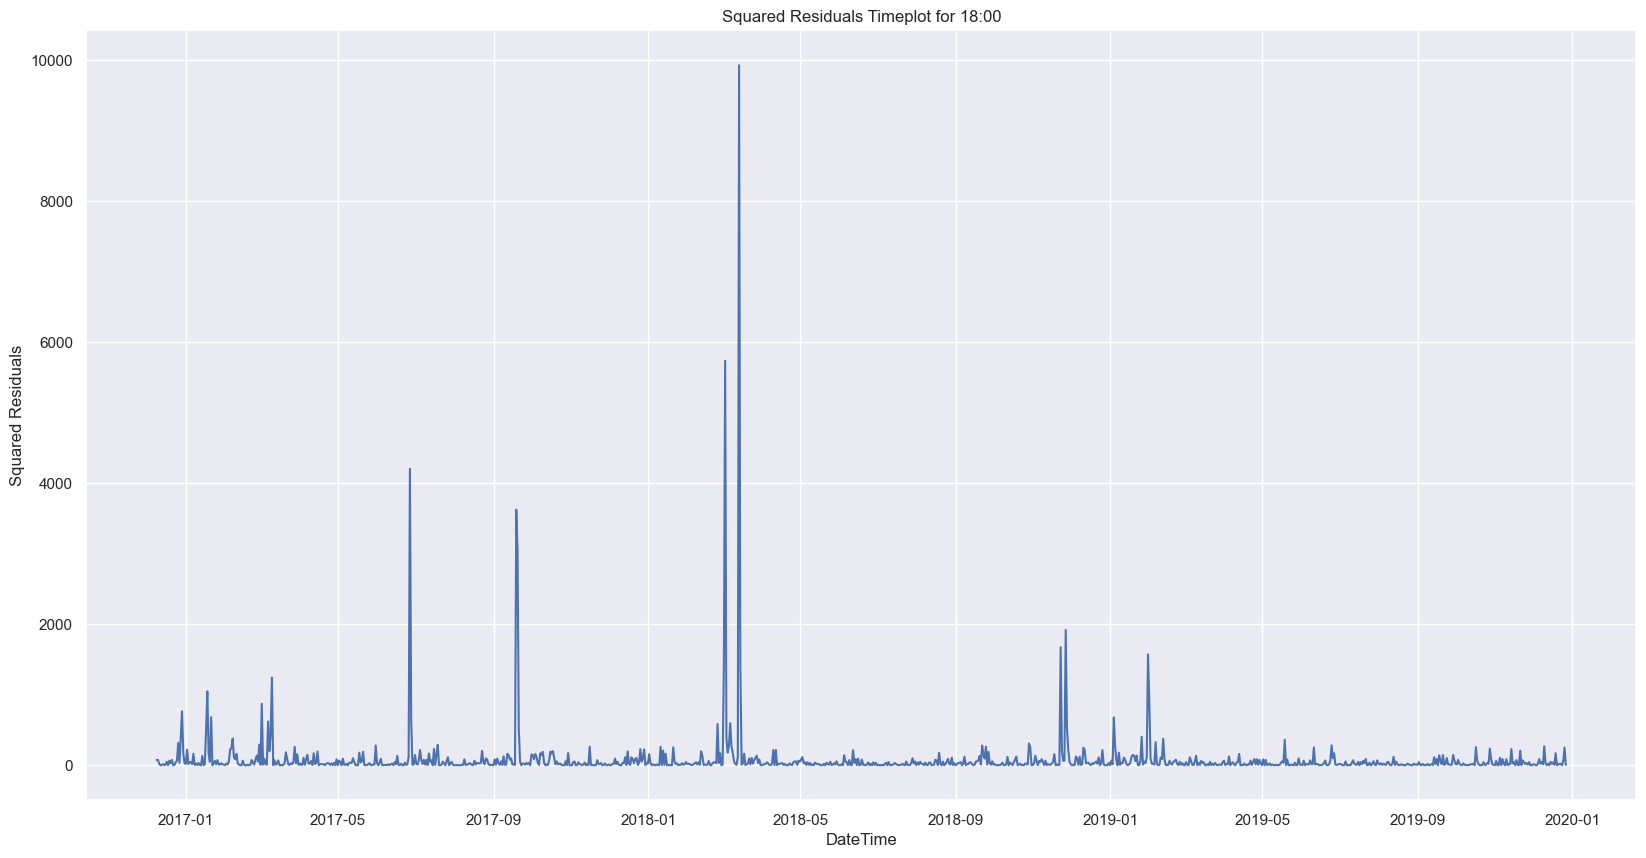

In [129]:
sns.lineplot(x=lasso_train[18].index, y=lasso_train[18]['Squared Residuals'])
plt.title('Squared Residuals Timeplot for 18:00')


## Garch Model

## Working an example

In [130]:
from arch import arch_model

# Using arch_lasso_exp as an example, variable b takes an int number pointing the hour 
# we want to produce the arch model

b = 5

arch_lasso_exp = arch_model(lasso_train[b]['Residual'], vol='GARCH', p=1,q=1, dist='normal', mean='zero')
arch_lasso_exp = arch_lasso_exp.fit()
arch_lasso_exp.summary()
arch_lasso_exp.forecast(horizon=len(lasso_test[b])).variance.values[-1, :]

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5866.345318798869
Iteration:      2,   Func. Count:     11,   Neg. LLF: 3420.307328866504
Iteration:      3,   Func. Count:     17,   Neg. LLF: 3394.800713810755
Iteration:      4,   Func. Count:     21,   Neg. LLF: 3393.9990993102583
Iteration:      5,   Func. Count:     25,   Neg. LLF: 3393.7751343393293
Iteration:      6,   Func. Count:     29,   Neg. LLF: 3393.7224171849007
Iteration:      7,   Func. Count:     33,   Neg. LLF: 3393.710958034813
Iteration:      8,   Func. Count:     37,   Neg. LLF: 3393.710184592467
Iteration:      9,   Func. Count:     41,   Neg. LLF: 3393.7101677884193
Iteration:     10,   Func. Count:     45,   Neg. LLF: 3393.710166865029
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3393.710166865029
            Iterations: 10
            Function evaluations: 45
            Gradient evaluations: 10


array([37.26526146, 30.4586459 , 28.61863851, 28.12123606, 27.98677509,
       27.95042675, 27.94060083, 27.93794463, 27.93722659, 27.93703248,
       27.93698001, 27.93696583, 27.93696199, 27.93696096, 27.93696067,
       27.9369606 , 27.93696058, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93696057,
       27.93696057, 27.93696057, 27.93696057, 27.93696057, 27.93

Text(0.5, 1.0, 'Volatility for 5:00')

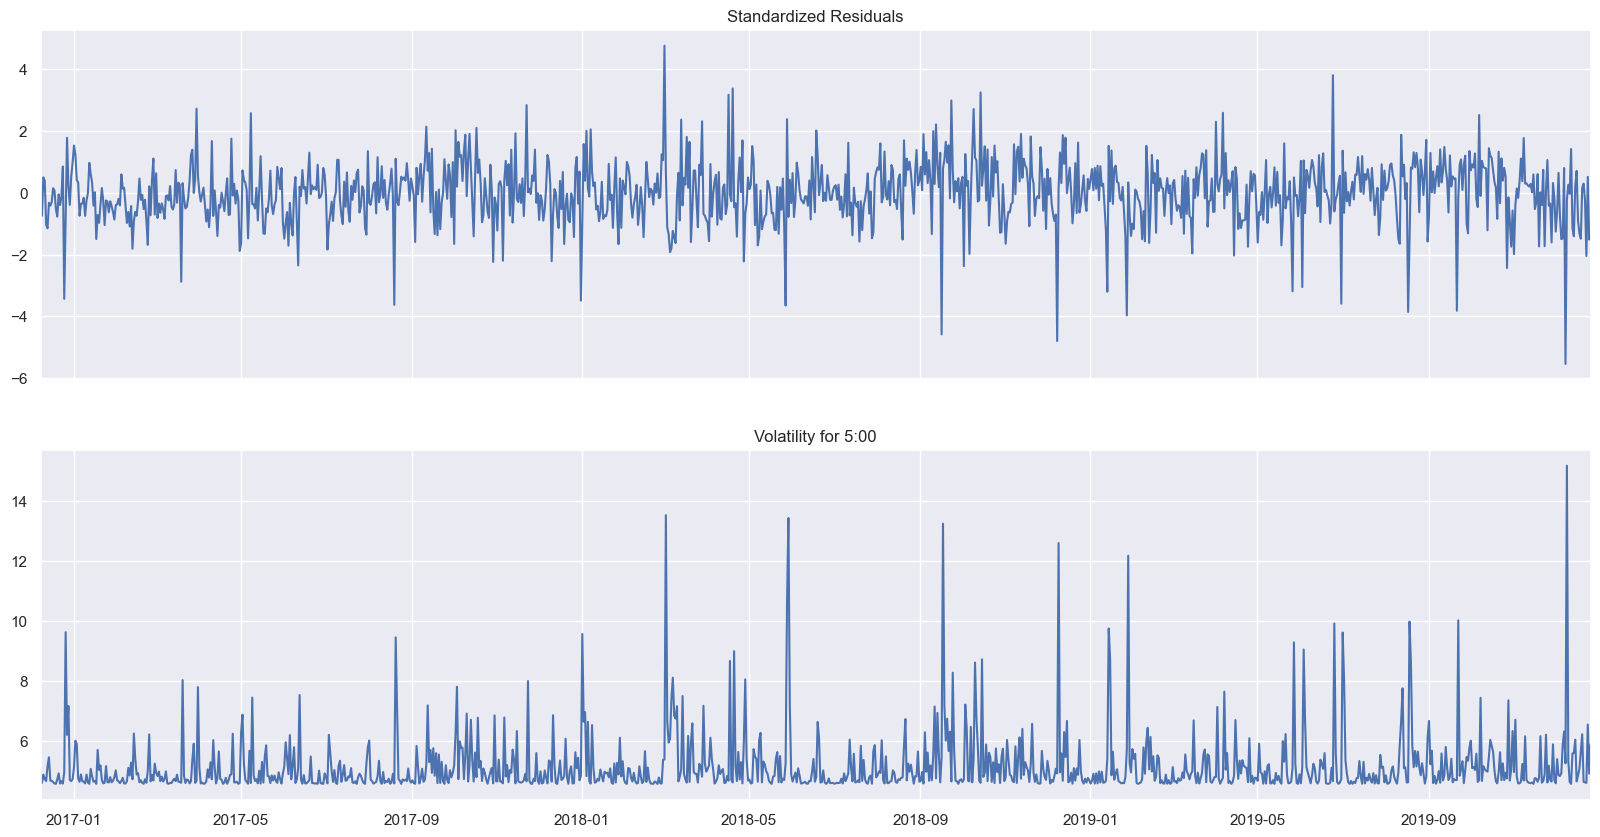

In [131]:
# Producing conditional volatility plot for our garch model

arch_lasso_exp.plot();
plt.title('Volatility for ' + str(b) + ':00')


Text(0.5, 1.0, 'Distribution of Standardized Residuals for GARCH(1,1) - 5:00')

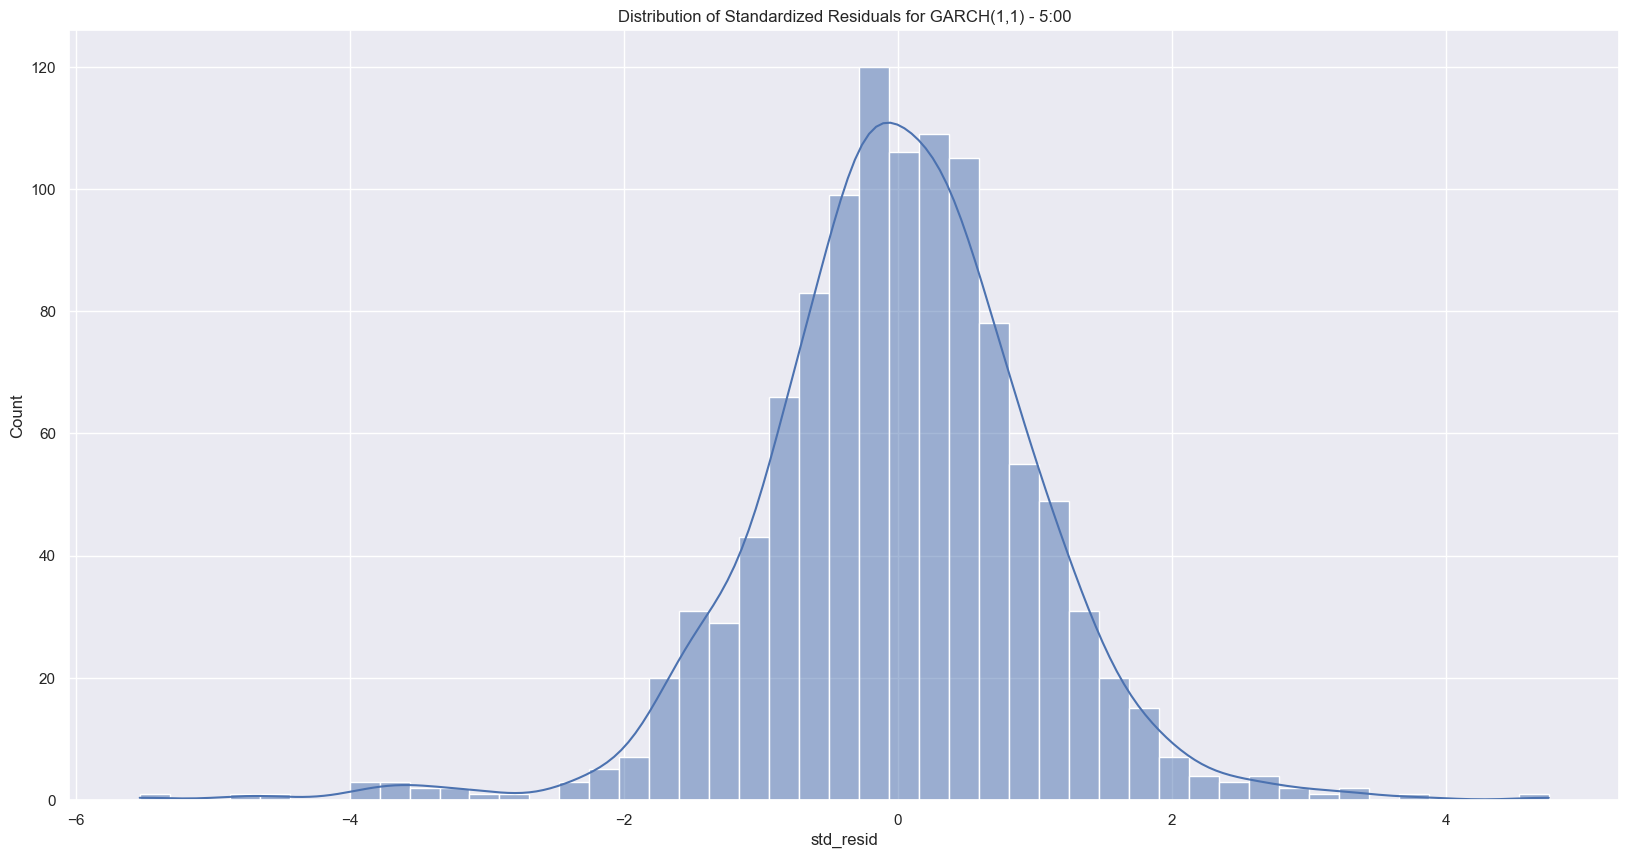

In [132]:
# Plotting the standardized residuals of our garch model

sns.histplot(arch_lasso_exp.std_resid, kde=True)
plt.title('Distribution of Standardized Residuals for GARCH(1,1) - ' + str(b) + ':00')

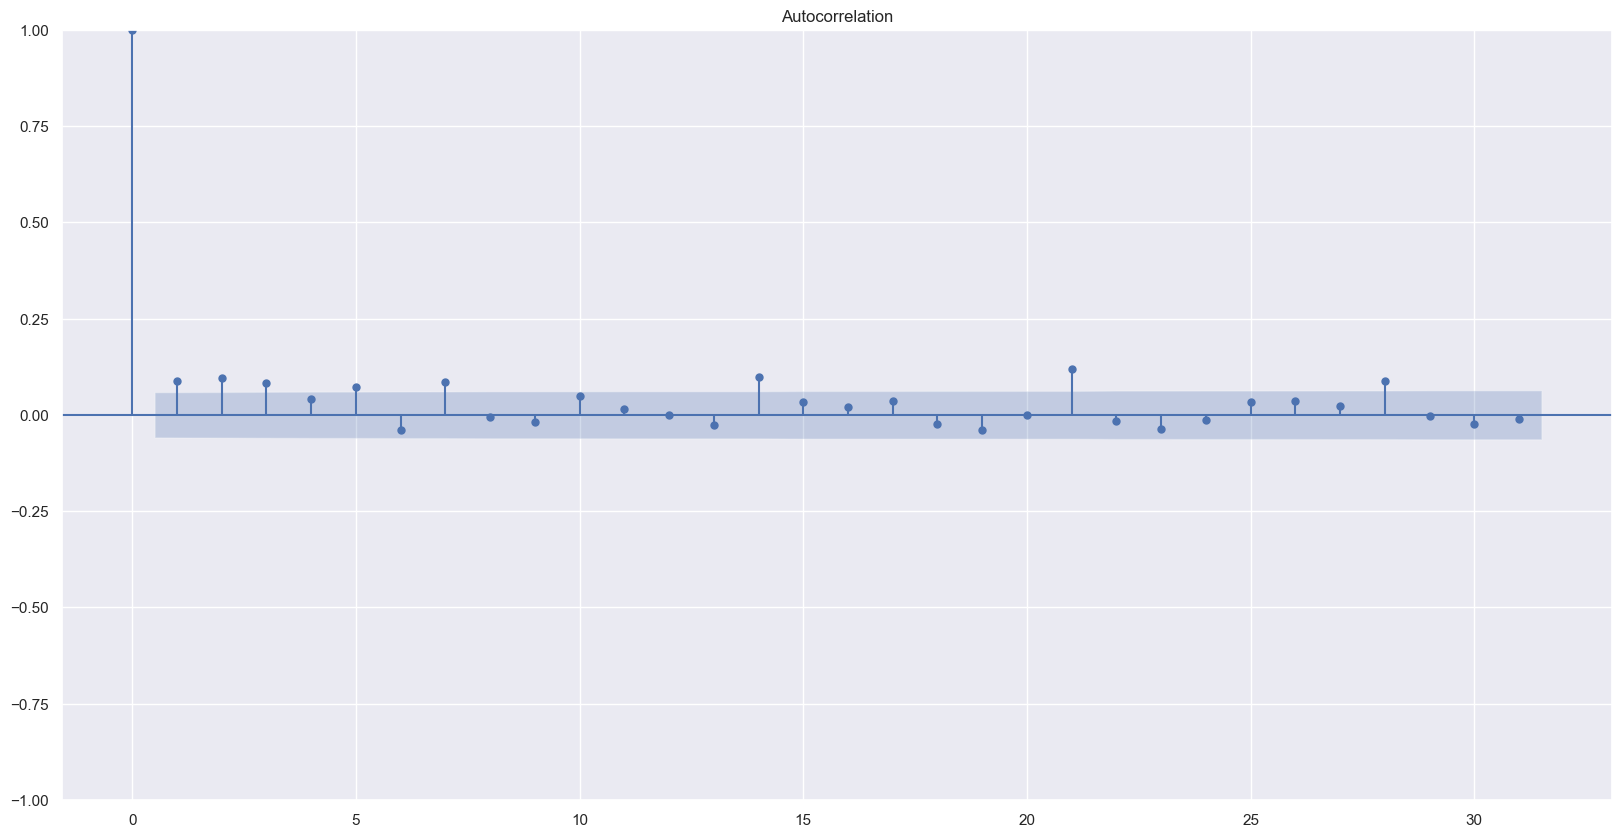

In [133]:
sm.graphics.tsa.plot_acf(arch_lasso_exp.std_resid);

Text(0.5, 1.0, 'QQplot for Standardized Residuals - GARCH(1,1) 5:00')

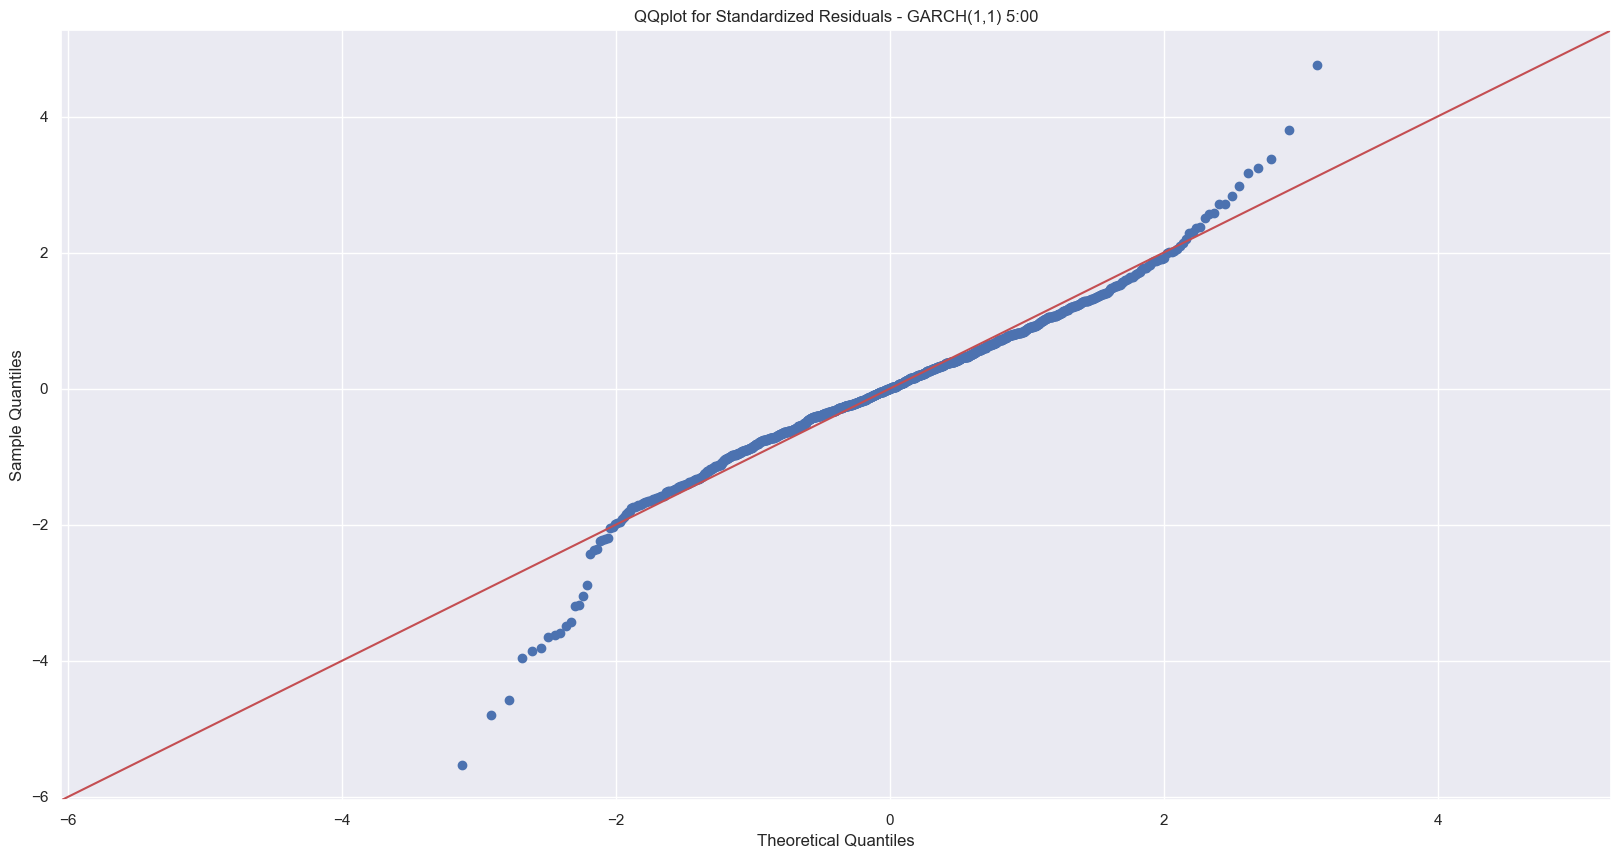

In [134]:
# Plotting the qqplot of our standardized residuals

import statsmodels.api as sm
import pylab

x = arch_lasso_exp.std_resid
sm.qqplot(x, line='45')

plt.title('QQplot for Standardized Residuals - GARCH(1,1) ' + str(b) + ':00')

## Training every model

In [135]:
# Training every garch model for every hour ( takes the residuals from our trained lasso models)

from scipy import stats
garch_lasso_train = {hour: pd.DataFrame() for hour in hours}

for hour in hours:
    garch_lasso_train[hour] = arch_model(lasso_train[hour]['Residual'], vol='GARCH', p=1,q=1, mean='zero').fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3017.3520283828066
Iteration:      2,   Func. Count:     11,   Neg. LLF: 2868.2704137173414
Iteration:      3,   Func. Count:     15,   Neg. LLF: 2869.111422554285
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2994.603763069357
Iteration:      5,   Func. Count:     26,   Neg. LLF: 2866.886953307399
Iteration:      6,   Func. Count:     30,   Neg. LLF: 2866.858927806472
Iteration:      7,   Func. Count:     34,   Neg. LLF: 2866.8552895345565
Iteration:      8,   Func. Count:     38,   Neg. LLF: 2866.8541001604804
Iteration:      9,   Func. Count:     42,   Neg. LLF: 2866.8540388043557
Iteration:     10,   Func. Count:     46,   Neg. LLF: 2866.854034407333
Iteration:     11,   Func. Count:     49,   Neg. LLF: 2866.8540344073035
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2866.854034407333
            Iterations: 11
            Function evaluations: 49
            Gradient evaluatio

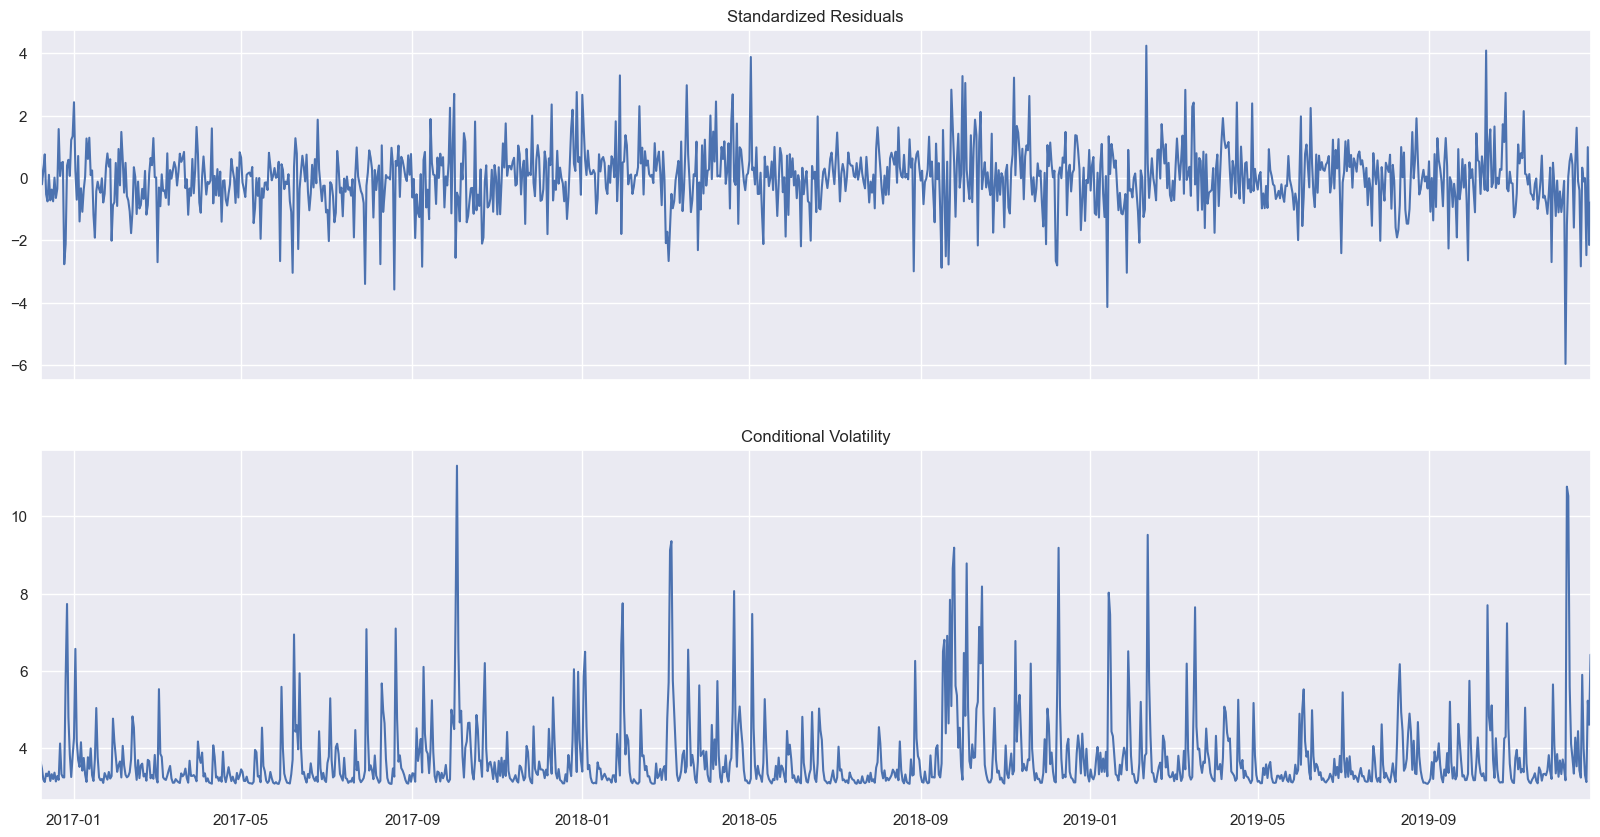

In [136]:
fig = garch_lasso_train[2].plot()

In [137]:
garch_lasso_results = {hour: pd.DataFrame() for hour in hours}

for hour in hours:
    garch_lasso_results[hour]['Actual Value'] = lasso_test[hour]['Actual Value']
    garch_lasso_results[hour]['Predicted Value'] = lasso_test[hour]['Predicted Value']
    garch_lasso_results[hour]['Residual'] = lasso_test[hour]['Residual']
    garch_lasso_results[hour]['Squared Residuals'] = lasso_test[hour]['Squared Residuals']
    garch_lasso_results[hour]['STD'] = np.sqrt(garch_lasso_train[hour].forecast(horizon=len(lasso_test[hour])).variance.values[-1, :])
    

In [138]:
garch_lasso_results[5].to_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\garch_lasso_results_5.csv')

# Lasso with constant standard deviation

In [139]:
# Residual and STD functions need attention

lasso_mean_results = {hour: pd.DataFrame() for hour in hours}
for hour in hours:
    lasso_mean_results[hour]['Actual Value'] = lasso_test[hour]['Actual Value']
    lasso_mean_results[hour]['Predicted Value'] = lasso_test[hour]['Predicted Value']
    lasso_mean_results[hour]['Error'] = lasso_test[hour]['Actual Value'] - lasso_test[hour]['Predicted Value']
    lasso_mean_results[hour]['Squared Errors'] = lasso_test[hour]['Squared Residuals']
    lasso_mean_results[hour]['STD'] = lasso_train[hour]['Residual'].std()

In [140]:
lasso_mean_results[4]

,Actual Value,Predicted Value,Error,Squared Errors,STD
DateTime,,,,,
2019-12-27 04:00:00,24.70,22.440192,2.259808,5.106733,4.690681
2019-12-28 04:00:00,19.04,22.335725,-3.295725,10.861804,4.690681
2019-12-29 04:00:00,17.79,18.648364,-0.858364,0.736789,4.690681
2019-12-30 04:00:00,19.92,18.731467,1.188533,1.412611,4.690681
2019-12-31 04:00:00,28.93,27.678201,1.251799,1.567002,4.690681
...,...,...,...,...,...
2020-09-26 04:00:00,25.82,27.975046,-2.155046,4.644224,4.690681
2020-09-27 04:00:00,16.83,28.717369,-11.887369,141.309537,4.690681
2020-09-28 04:00:00,42.00,33.579271,8.420729,70.908668,4.690681


# Lasso - ARIMA Model

## Trainning ARIMA and Parameter Estimation

In [141]:
import statsmodels.api as sm
import pmdarima as pm

In [142]:
arima_train = {hour: pd.DataFrame() for hour in hours}
arima_order = {hour: pd.DataFrame() for hour in hours}

arima_hour = []
arima_pqd = []

for hour in hours:
    arima_train[hour] = pm.auto_arima(lasso_train[hour]['Residual'],
                                      test='adf',
                                      suppress_warnings=True,
                                      stepwise=True,
                                      trace=False,
                                      information_criterion='aic')
    arima_hour.append('ARMA-D on HOUR_ '+ str(hour))
    arima_pqd.append(arima_train[hour].order)


In [143]:
arima_order_df = pd.DataFrame(columns=['Arima Model', 'Arima Order'])
arima_order_df['Arima Model'] = arima_hour
arima_order_df['Arima Order'] = arima_pqd
arima_order_df

,Arima Model,Arima Order
0,ARMA-D on HOUR_ 0,"(1, 0, 1)"
1,ARMA-D on HOUR_ 1,"(1, 0, 1)"
2,ARMA-D on HOUR_ 2,"(1, 0, 2)"
3,ARMA-D on HOUR_ 3,"(2, 0, 1)"
4,ARMA-D on HOUR_ 4,"(1, 0, 1)"
5,ARMA-D on HOUR_ 5,"(1, 0, 1)"
6,ARMA-D on HOUR_ 6,"(2, 0, 2)"
7,ARMA-D on HOUR_ 7,"(1, 0, 1)"
8,ARMA-D on HOUR_ 8,"(2, 0, 1)"
9,ARMA-D on HOUR_ 9,"(1, 0, 1)"


In [82]:
arima_order_df.to_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\day_ahead_demand_parameters\ARMA-D_parameters.csv')

In [374]:
lasso_arima_results = {hour: pd.DataFrame() for hour in hours}
arima_forecast = {hour: pd.DataFrame() for hour in hours}
mae_arima = []
rmse_arima = []
model_name = []

for hour in hours:
    arima_forecast[hour] = arima_train[hour].predict(n_periods=len(lasso_test[hour]))

for hour in hours:
    lasso_arima_results[hour]['Actual Value'] = lasso_test[hour]['Actual Value']
    lasso_arima_results[hour]['Predicted Mean Value'] = lasso_test[hour]['Predicted Value']
    lasso_arima_results[hour]['Predicted Residual'] = arima_forecast[hour]
    lasso_arima_results[hour]['Predicted Value'] = lasso_arima_results[hour]['Predicted Mean Value'] + lasso_arima_results[hour]['Predicted Residual']
    lasso_arima_results[hour]['Error'] = lasso_arima_results[hour]['Actual Value'] - lasso_arima_results[hour]['Predicted Value']
    lasso_arima_results[hour]['STD'] = (lasso_train[hour]['Residual']-arima_train[hour].predict_in_sample()).std()
    mae = mean_absolute_error(lasso_arima_results[hour]['Actual Value'], lasso_arima_results[hour]['Predicted Value'])
    rmse = mean_squared_error(lasso_arima_results[hour]['Actual Value'], lasso_arima_results[hour]['Predicted Value'])
    mae_arima.append(mae)
    rmse_arima.append(rmse)
    model_name.append('lasso_arima_model[' + str(hour) + ']')
    
lasso_arima_scores = pd.DataFrame(columns=['Model', 'MAE', 'RMSE'])
lasso_arima_scores['Model'] = model_name
lasso_arima_scores['MAE'] = mae_arima
lasso_arima_scores['RMSE'] = rmse_arima

In [375]:
lasso_arima_scores['MAE'].mean()

4.333104529730932

In [376]:
lasso_arima_scores['RMSE'].mean()

44.435719161239426

# Evaluation Metrics

## Reliability Diagrams

In [379]:
from ProbEval import reliability_diagram

In [387]:
%%capture

# h = 5

# reliability_diagram(lasso_arima_results[h],obs='Actual Value',mu='Predicted Value',std='STD',plot=True,c='red',l='LASSO-ARMA_'+str(h),m='o')
# reliability_diagram(lasso_mean_results[h],obs='Actual Value',mu='Predicted Value',std='STD',plot=True,c='green',l='LASSO-BENACHMARK_'+str(h),m='o')
# reliability_diagram(garch_lasso_results[h],obs='Actual Value',mu='Predicted Value',std='STD',plot=True,c='blue',l='LASSO-GARCH_'+str(h),m='s')

    
fig = {hour: pd.DataFrame() for hour in hours}    

for h in hours:
    fig[h] = plt.figure()
    reliability_diagram(lasso_arima_results[h],obs='Actual Value',mu='Predicted Value',std='STD',plot=True,c='red',l='LASSO-ARMA_'+str(h),m='o')
    reliability_diagram(lasso_mean_results[h],obs='Actual Value',mu='Predicted Value',std='STD',plot=True,c='green',l='LASSO-BENACHMARK_'+str(h),m='o')
    reliability_diagram(garch_lasso_results[h],obs='Actual Value',mu='Predicted Value',std='STD',plot=True,c='blue',l='LASSO-GARCH_'+str(h),m='s')
   

    
    
for h in hours:    
    fig[h].savefig(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\day_ahead_reliability\Reliability Diagram_without_demand_' +str(h)+'.png')


## CRPS

In [321]:
from ProbEval import crps_norm

In [322]:
crps_score_table = pd.DataFrame(columns=('Model', 'LASSO-GARCH CRPS', 'LASSO Benchmark CRPS', 'LASSO-ARIMA CRPS'))
lasso_garch_crps = {hour: pd.DataFrame() for hour in hours}
lasso_mean_crps = {hour: pd.DataFrame() for hour in hours}
lasso_arima_crps = {hour: pd.DataFrame() for hour in hours}

l_g_crps = []
l_m_crps = []
l_a_crps = []
h = []


for hour in hours:
    lasso_garch_crps[hour] = crps_norm(garch_lasso_results[hour],
                                 obs='Actual Value',
                                 m='Predicted Value',
                                 sigma='STD')
    l_g_crps.append(np.mean(lasso_garch_crps[hour]))

    lasso_mean_crps[hour] = crps_norm(lasso_mean_results[hour],
                                      obs='Actual Value',
                                      m='Predicted Value',
                                      sigma='STD')
    l_m_crps.append(np.mean(lasso_mean_crps[hour]))

    lasso_arima_crps[hour] = crps_norm(lasso_arima_results[hour],
                                       obs='Actual Value',
                                       m='Predicted Value',
                                       sigma='STD')
    l_a_crps.append(np.mean(lasso_arima_crps[hour]))

    h.append('Model at time: '+ str(hour))


crps_score_table['Model'] = h
crps_score_table['LASSO-GARCH CRPS'] = l_g_crps
crps_score_table['LASSO Benchmark CRPS'] = l_m_crps
crps_score_table['LASSO-ARIMA CRPS'] = l_a_crps 



In [323]:
crps_score_table

,Model,LASSO-GARCH CRPS,LASSO Benchmark CRPS,LASSO-ARIMA CRPS
0,Model at time: 0,1.400620,1.399618,1.396567
1,Model at time: 1,2.098220,2.092809,2.087974
2,Model at time: 2,2.508536,2.508207,2.501709
3,Model at time: 3,2.891100,2.891422,2.891007
4,Model at time: 4,3.426413,3.419133,3.437039
5,Model at time: 5,3.922122,3.925262,3.929871
6,Model at time: 6,4.635189,4.640152,4.651243
7,Model at time: 7,4.394121,4.395443,4.402129
8,Model at time: 8,3.326212,3.328945,3.327909
9,Model at time: 9,2.926438,2.931027,2.931795


In [324]:
crps_score_table['LASSO-GARCH CRPS'].mean()

3.374646326684387

In [325]:
crps_score_table['LASSO Benchmark CRPS'].mean()

3.346276526414956

In [326]:
crps_score_table['LASSO-ARIMA CRPS'].mean()

3.345274112697464

## Pinball Loss

In [149]:
from ProbEval import pinball_loss_norm

In [150]:
# %%capture

# fig = {hour: pd.DataFrame() for hour in hours}


# for h in hours:
#     %load_ext autoreload

#     %autoreload 2


#     pinball_loss_norm(lasso_arima_results[h],
#                       obs='Actual Value',
#                       mu='Predicted Value',
#                       std='STD',
#                       l='Lasso-ARIMA' + str(h),
#                       c='blue')
#     pinball_loss_norm(garch_lasso_results[h],
#                       obs='Actual Value',
#                       mu='Predicted Value',
#                       std='STD',
#                       l='GARCH-Lasso' + str(h),
#                       c='red')
#     pinball_loss_norm(lasso_mean_results[h],
#                       obs='Actual Value',
#                       mu='Predicted Value',
#                       std='STD',
#                       l='Lasso Constant Std' + str(h),
#                       c='green')
#     fig[h] = plt.figure()

# for h in hours:
#     fig[h].savefig(r'C:\Users\2836589S\OneDrive - University of Glasgow\VScode Projects\Price Timeseries UK\Plots\Pinball Loss Diagrams\Pinball Loss_'+str(h)+'.png')

    

In [151]:
h = 2

In [152]:
lasso_test[2]

,Actual Value,Predicted Value,Residual,Squared Residuals
DateTime,,,,
2019-12-27 02:00:00,24.99,29.481335,-4.491335,20.172090
2019-12-28 02:00:00,23.09,24.936940,-1.846940,3.411187
2019-12-29 02:00:00,19.99,22.518173,-2.528173,6.391657
2019-12-30 02:00:00,19.81,20.749638,-0.939638,0.882920
2019-12-31 02:00:00,31.05,31.560433,-0.510433,0.260542
...,...,...,...,...
2020-09-26 02:00:00,20.57,24.742589,-4.172589,17.410498
2020-09-27 02:00:00,11.31,22.844003,-11.534003,133.033227
2020-09-28 02:00:00,26.88,25.227233,1.652767,2.731640


<AxesSubplot:xlabel='DateTime', ylabel='Actual Value'>

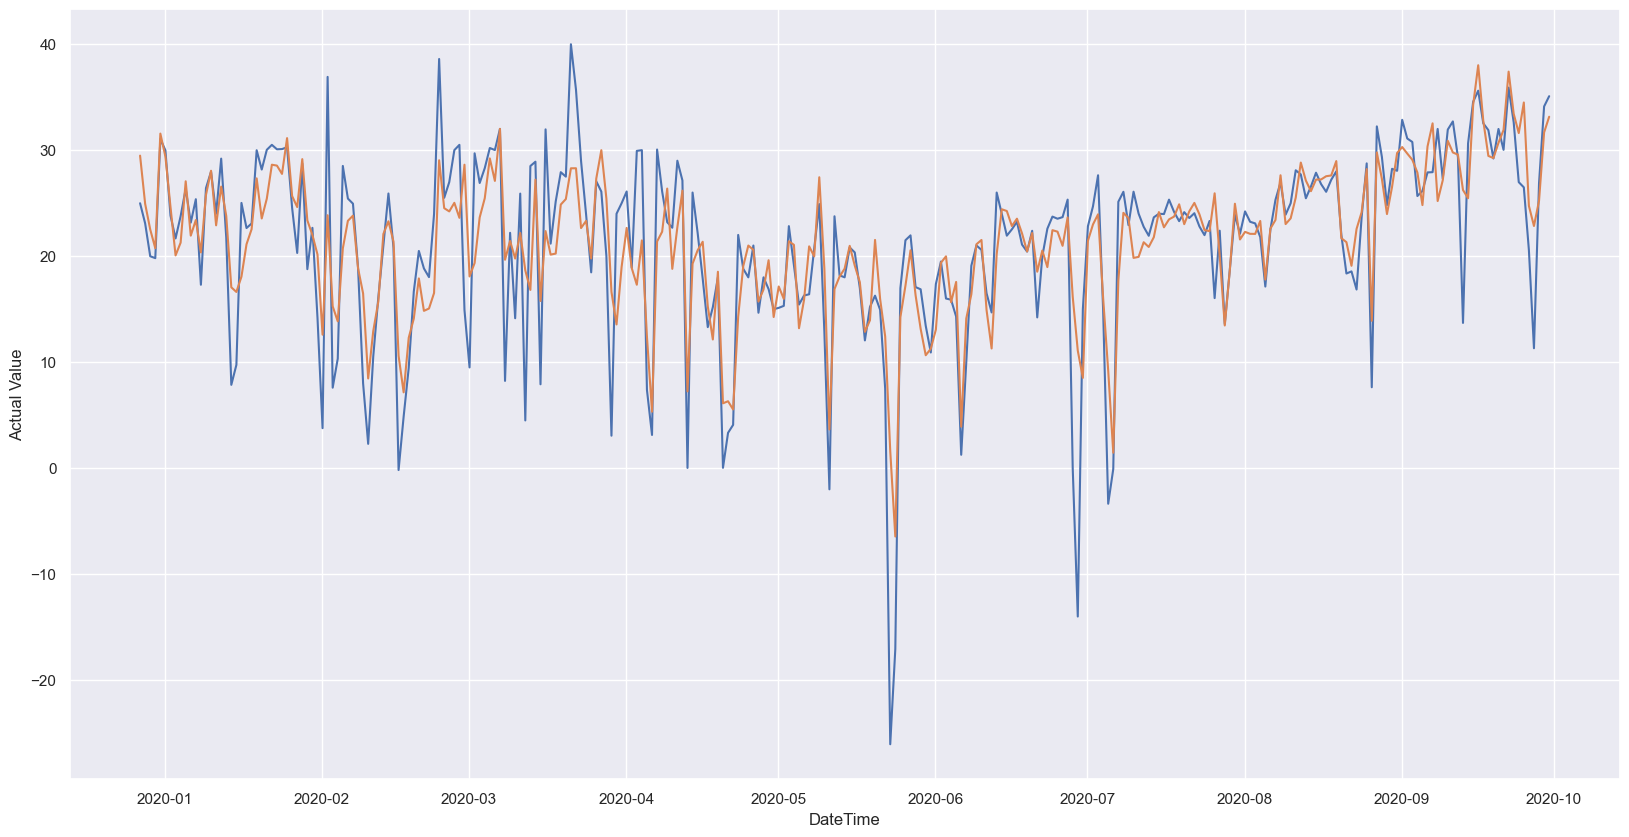

In [153]:
sns.lineplot(x=lasso_test[h].index, y=lasso_test[h]['Actual Value'])
sns.lineplot(x=lasso_test[h].index, y=lasso_test[h]['Predicted Value'])

In [154]:
crps_lasso_garch = crps_norm(garch_lasso_results[h],obs='Actual Value',m='Predicted Value',sigma='STD')


# Random Forest

In [155]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [156]:
param={'n_estimators':[100,300,500]}

In [157]:
# Create empty dataframes with hour as index in order to fill the trained models, and train them accordingly
model_rf = {hour: pd.DataFrame() for hour in hours}
train_pred = {hour: pd.DataFrame() for hour in hours}
test_pred = {hour: pd.DataFrame() for hour in hours}




# We will traing every model for every hour, and we generate a data frame that will inform us about the r-squared,
# alpha value and intercept for every model

rsquared_test_rf = []
rsquared_train_rf = []
model_name_rf = []
random_pred = []


# grid = GridSearchCV(RandomForestRegressor(), param_grid=param, cv=tscv, n_jobs=-1)

regressor = RandomForestRegressor(n_estimators=300)

for hour in hours:
    model_rf[hour] = regressor.fit(X_train[hour], y_train[hour])
    train_pred[hour] = model_rf[hour].predict(X_train[hour])
    test_pred[hour] = model_rf[hour].predict(X_test[hour])
    train_score = r2_score(y_train[hour], train_pred[hour])
    test_score = r2_score(y_test[hour], test_pred[hour])

    rsquared_train_rf.append(train_score)
    rsquared_test_rf.append(test_score)

    model_name_rf.append('rf_model[' + str(hour) + ']')

model_results_rf = pd.DataFrame(columns=['Model', 'Rsquared Value Train', 'Rsquared Value Test'])
model_results_rf['Model'] = model_name_rf
model_results_rf['Rsquared Value Train'] = rsquared_train_rf
model_results_rf['Rsquared Value Test'] = rsquared_test_rf



# Table that shows the results for every trained model
model_results_rf

,Model,Rsquared Value Train,Rsquared Value Test
0,rf_model[0],0.983007,0.615577
1,rf_model[1],0.980156,0.547392
2,rf_model[2],0.975099,0.483523
3,rf_model[3],0.970484,0.463573
4,rf_model[4],0.965263,0.424186
5,rf_model[5],0.964534,0.372915
6,rf_model[6],0.956954,0.276880
7,rf_model[7],0.952183,0.130047
8,rf_model[8],0.950886,-0.111667
9,rf_model[9],0.958051,0.006944


In [158]:
model_results_rf['Rsquared Value Train'].mean()

0.9636751755993855

In [159]:
model_results_rf['Rsquared Value Test'].mean()

0.16236005402673434

<AxesSubplot:xlabel='DateTime', ylabel='Actual'>

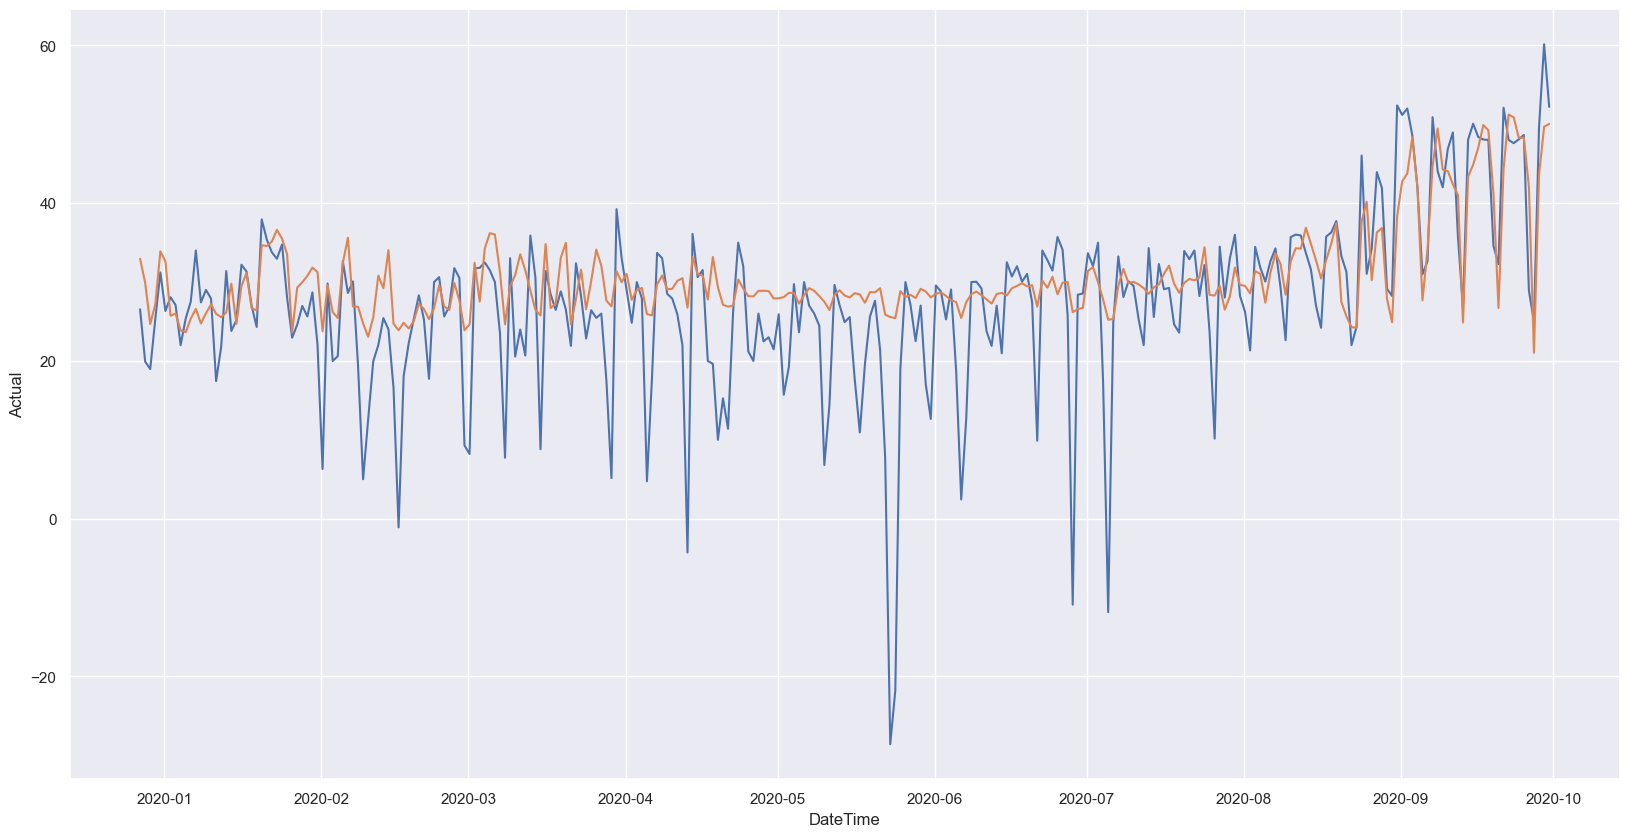

In [160]:
h = 5

inspection_df = pd.DataFrame()
inspection_df['Actual'] = y_test[h]
inspection_df['Predicted'] = test_pred[h]
sns.lineplot(x=inspection_df.index, y=inspection_df['Actual'])
sns.lineplot(x=inspection_df.index, y=inspection_df['Predicted'])

# Lasso with dummy variables

## Creating dummy variables

In [161]:
df_model_dummies = df_model[['Price', 'Solar Generation', 'Wind OffGeneration', 'Wind OnGeneration']]

In [162]:
df_model_dummies['Month'] = df_model_dummies.index.month
df_model_dummies['Day'] = df_model_dummies.index.dayofweek
df_model_dummies['Week'] = df_model_dummies.index.weekofyear
df_model_dummies['Day_of_Week'] = df_model_dummies.index.dayofweek
df_model_dummies['Hour'] = df_model.index.hour
df_model_dummies


,Price,Solar Generation,Wind OffGeneration,Wind OnGeneration,Month,Day,Week,Day_of_Week,Hour
DateTime,,,,,,,,,
2016-12-07 23:00:00,37.92,0.0,7.709530,8.466638,12,2,49,2,23
2016-12-08 00:00:00,37.76,0.0,7.517084,8.300161,12,3,49,3,0
2016-12-08 01:00:00,36.25,0.0,7.392779,8.231132,12,3,49,3,1
2016-12-08 02:00:00,36.09,0.0,7.266433,8.149012,12,3,49,3,2
2016-12-08 03:00:00,34.25,0.0,7.144611,8.020376,12,3,49,3,3
...,...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00,46.55,0.0,9.389641,7.312490,9,2,40,2,19
2020-09-30 20:00:00,40.95,0.0,9.401640,7.256017,9,2,40,2,20
2020-09-30 21:00:00,34.84,0.0,9.361170,7.177128,9,2,40,2,21


In [163]:

df_lasso_dummies ={hour: pd.DataFrame() for hour in hours}
for i in range(len(hours)):
    df_lasso_dummies[i] = df_model_dummies[df_model_dummies['Hour'] == i]

for i in range(len(hours)):
    df_lasso_dummies[i].drop(columns='Hour', inplace=True)

# Example of the dataset of 00:00    
df_lasso_dummies[0]
    


,Price,Solar Generation,Wind OffGeneration,Wind OnGeneration,Month,Day,Week,Day_of_Week
DateTime,,,,,,,,
2016-12-08,37.76,0.0,7.517084,8.300161,12,3,49,3
2016-12-09,40.44,0.0,5.556315,6.931569,12,4,49,4
2016-12-10,40.25,0.0,7.366115,8.002128,12,5,49,5
2016-12-11,40.93,0.0,6.666060,7.944538,12,6,49,6
2016-12-12,37.34,0.0,4.822199,5.824396,12,0,50,0
...,...,...,...,...,...,...,...,...
2020-09-26,26.20,0.0,9.695505,8.391436,9,5,39,5
2020-09-27,16.95,0.0,9.394737,7.199829,9,6,39,6
2020-09-28,27.61,0.0,8.139418,5.907768,9,0,40,0


## Splitting to train and test

In [164]:
X_train = {hour: pd.DataFrame() for hour in hours}
y_train = {hour: pd.DataFrame() for hour in hours}
X_test = {hour: pd.DataFrame() for hour in hours}
y_test = {hour: pd.DataFrame() for hour in hours}

for hour in range(len(hours)):
    X_train[hour], X_test[hour], y_train[hour], y_test[hour] = train_test_split(df_lasso_dummies[hour].drop(columns='Price'),
                                                                                df_lasso_dummies[hour]['Price'],
                                                                                test_size=0.20,
                                                                                shuffle=False)

## Model Trainning

In [165]:
from sklearn.preprocessing import OneHotEncoder


# Create empty dataframes with hour as index in order to fill the trained models, and train them accordingly
model_train = {hour: pd.DataFrame() for hour in hours}
train_pred = {hour: pd.DataFrame() for hour in hours}
test_pred = {hour: pd.DataFrame() for hour in hours}



# We will traing every model for every hour, and we generate a data frame that will inform us about the r-squared,
# alpha value and intercept for every model

rsquared_dummies_test = []
rsquared_dummies_train = []
model_dummies_name = []


for hour in hours:
    numeric_features = ['Solar Generation', 'Wind OffGeneration', 'Wind OnGeneration']
    categorical_features = X_train[hour].drop(columns=['Solar Generation', 'Wind OffGeneration', 'Wind OnGeneration']).columns.to_list()

    numeric_transformer = Pipeline(
        steps=[("scaler", StandardScaler())]
    )

    categorical_transformer = Pipeline(
        steps=[("encoder", OneHotEncoder())]
    )

    preprocessor = ColumnTransformer(
        transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
        ]
    )

    lasso_with_dummies = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", LassoCV(cv=tscv))]
    )

    model_train[hour] = lasso_with_dummies.fit(X_train[hour], y_train[hour])
    train_pred[hour] = model_train[hour].predict(X_train[hour])
    test_pred[hour] = model_train[hour].predict(X_test[hour])
    train_score = r2_score(y_train[hour], train_pred[hour])
    test_score = r2_score(y_test[hour], test_pred[hour])
    
    rsquared_dummies_train.append(train_score)
    rsquared_dummies_test.append(test_score)
    
    

    model_dummies_name.append('model[' + str(hour) + ']')

model_dummies_results = pd.DataFrame(columns=['Model', 'Rsquared Value Train', 'Rsquared Value Test'])
model_dummies_results['Model'] = model_dummies_name
model_dummies_results['Rsquared Value Train'] = rsquared_dummies_train
model_dummies_results['Rsquared Value Test'] = rsquared_dummies_test



# Table that shows the results for every trained model
model_dummies_results

,Model,Rsquared Value Train,Rsquared Value Test
0,model[0],0.095901,-3.694069
1,model[1],0.124406,-3.174464
2,model[2],0.110042,-2.678019
3,model[3],0.100071,-2.112621
4,model[4],0.000000,-2.240057
5,model[5],0.165918,-1.543571
6,model[6],0.257128,-1.010894
7,model[7],0.268974,-1.532372
8,model[8],0.180215,-2.637239
9,model[9],0.143751,-2.309174


In [166]:
lasso_with_dummies

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Solar Generation',
                                                   'Wind OffGeneration',
                                                   'Wind OnGeneration']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Month', 'Day', 'Week',
                                                   'Day_of_Week'])])),
                ('regressor',
                 LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)))])

<AxesSubplot:xlabel='DateTime', ylabel='Actual'>

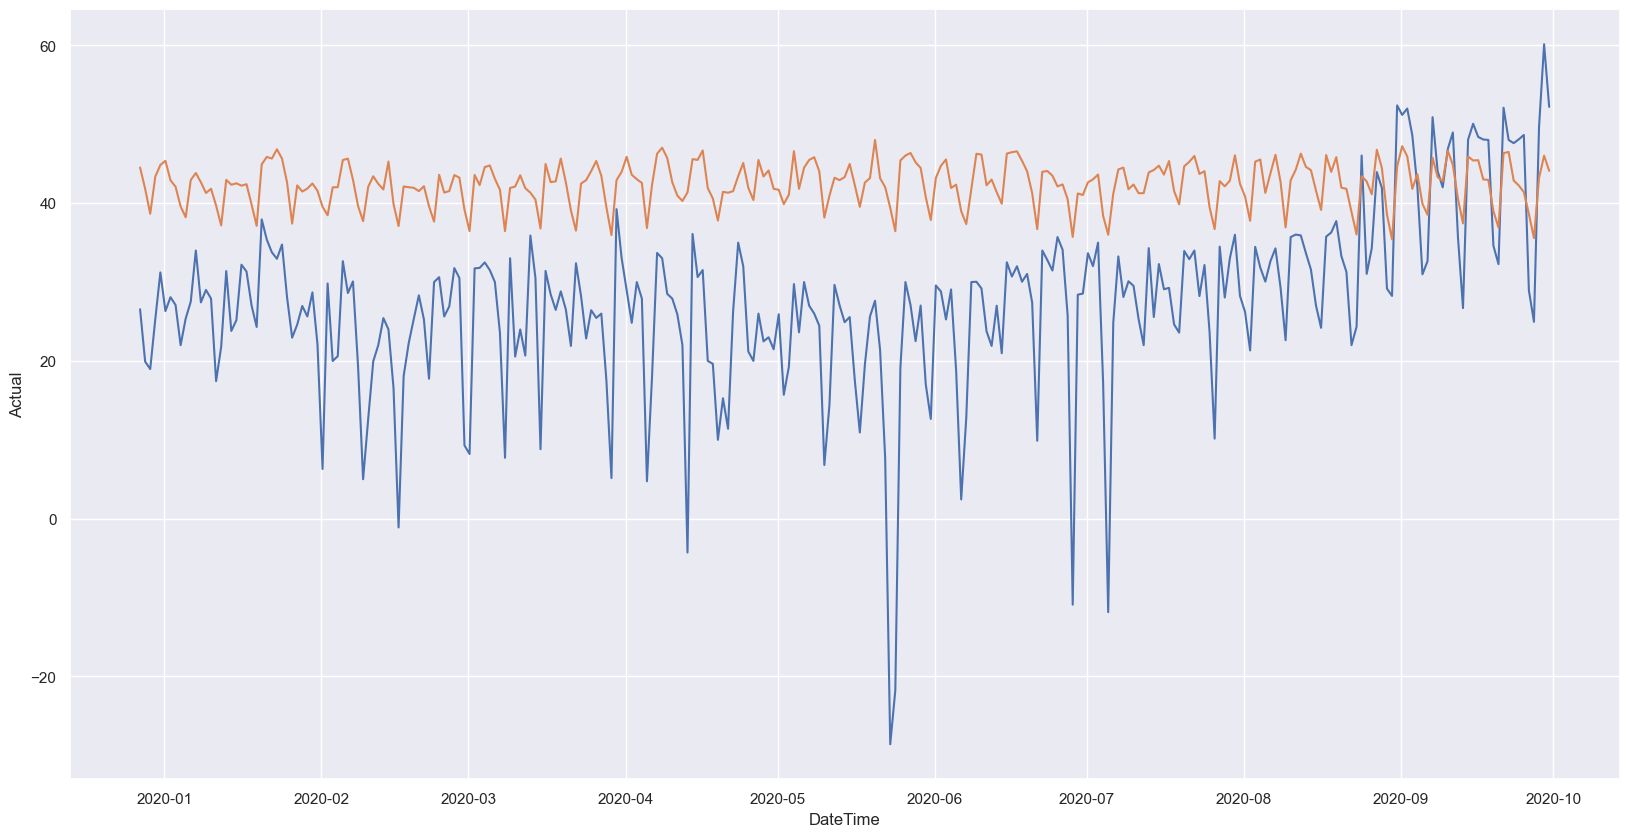

In [167]:
h = 5

inspection_df = pd.DataFrame()
inspection_df['Actual'] = y_test[h]
inspection_df['Predicted'] = test_pred[h]
sns.lineplot(x=inspection_df.index, y=inspection_df['Actual'])
sns.lineplot(x=inspection_df.index, y=inspection_df['Predicted'])

# Quantile Regression

In [91]:
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss

In [43]:
data = df_hour[1][['Price','Wind OffGeneration', 'Wind OnGeneration','Solar Generation','Price_Recent', 'Price_24', 'Price_167']]

In [44]:
data

,Price,Wind OffGeneration,Wind OnGeneration,Solar Generation,Price_Recent,Price_24,Price_167
DateTime,,,,,,,
2016-12-08 01:00:00,36.25,2986.97,4590.27,0.0,37.92,36.99,39.59
2016-12-09 01:00:00,37.33,989.59,2440.66,0.0,40.87,36.25,40.48
2016-12-10 01:00:00,40.26,2705.68,4038.47,0.0,43.58,37.33,40.29
2016-12-11 01:00:00,38.59,2073.47,4114.45,0.0,42.07,40.26,38.00
2016-12-12 01:00:00,37.02,429.59,1246.44,0.0,37.41,38.59,32.36
...,...,...,...,...,...,...,...
2020-09-26 01:00:00,23.23,8847.27,4908.71,0.0,28.71,33.97,29.21
2020-09-27 01:00:00,13.69,7654.24,2511.73,0.0,18.77,23.23,32.00
2020-09-28 01:00:00,26.77,4323.23,1391.80,0.0,28.85,13.69,30.03


In [38]:
tscv = TimeSeriesSplit(n_splits=5)

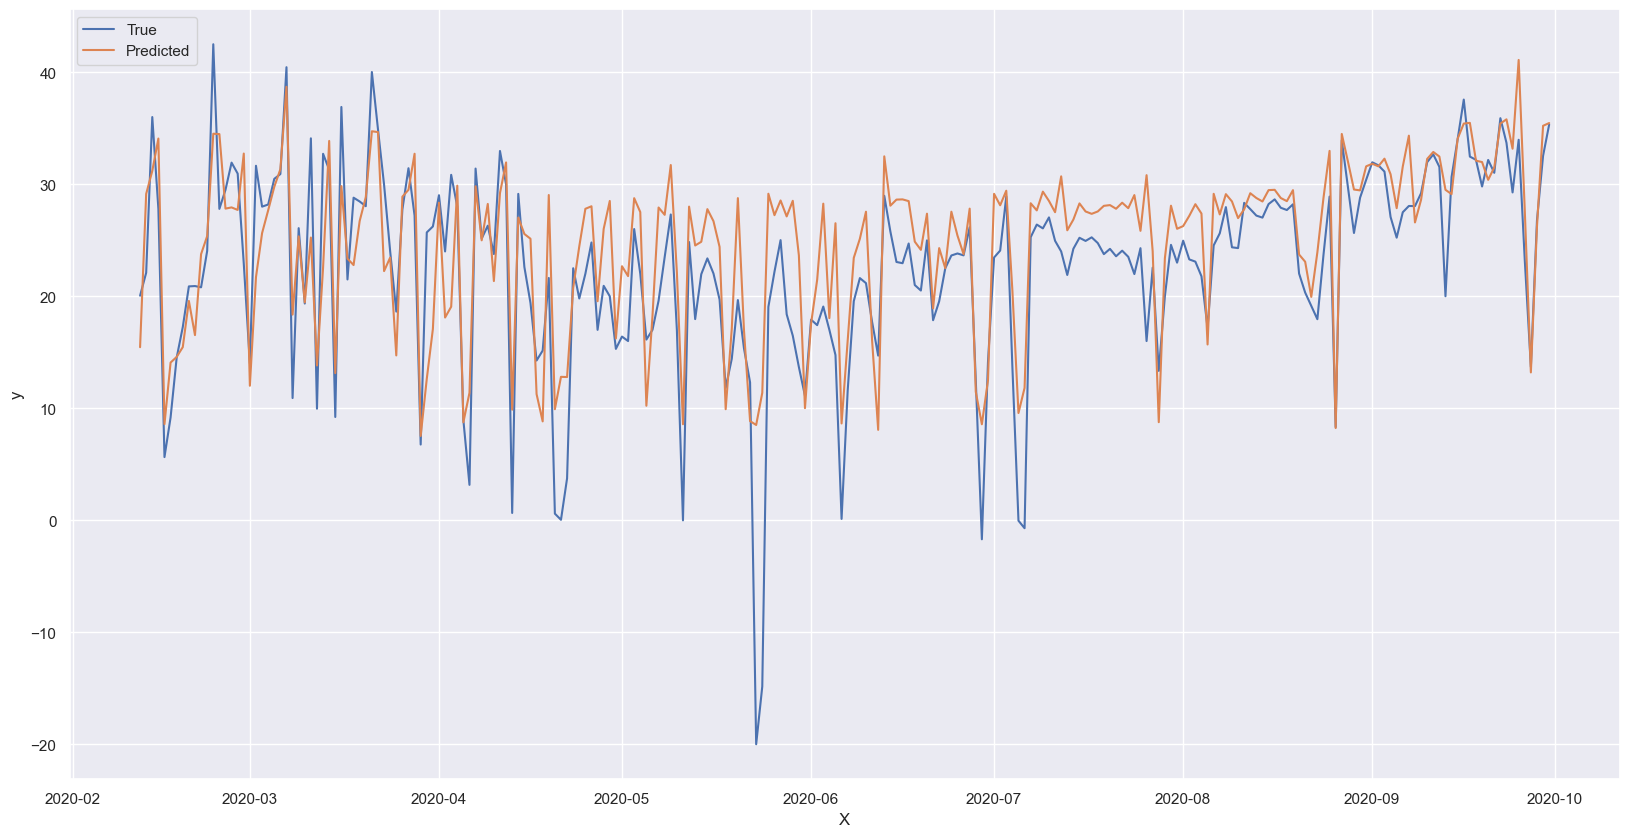

In [90]:
for train_index, test_index in tscv.split(data):
    train_data = data[:test_index[0]]
    test_data = data[test_index[0]:test_index[-1]+1]
    y = train_data['Price']
    X =  train_data.drop(columns=['Price'])
    X_test = test_data.drop(columns=['Price'])
    y_test = test_data['Price']
    gbr = GradientBoostingRegressor(loss='quantile', alpha=0.6)
    gbr_fit = gbr.fit(X, y)
    metric = mean_pinball_loss
    

y_pred = gbr_predict = gbr_fit.predict(X_test)
plt.plot(X_test.index, y_test, label='True')
plt.plot(X_test.index, y_pred, label='Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()